# TRAINING NOTEBOOK

## Environment

In [1]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
# Change main system path to be able to run code from src folder
import sys
p = sys.path[0]
# Mac OS
if sys.path[0].endswith('/notebooks'):
    main_path = p[:-len('/notebooks')]
if sys.path[0].endswith('/techdoc/content'):
    main_path = p[:-len('/techdoc/content')]
    
# Windows OS
if sys.path[0].endswith('\\notebooks'): 
    main_path = p[:-len('\\notebooks')]
if sys.path[0].endswith('\\techdoc\content'): 
    main_path = p[:-len('\\techdoc\content')]

sys.path[0] = main_path

In [3]:
import os, gc
from termcolor import colored
from tqdm import tqdm

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.metrics import log_loss

from scipy.signal import find_peaks
from scipy.ndimage.filters import gaussian_filter1d

from src import (config, features, preprocess, training)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


# DATA PREPARATION

In [4]:
# ===== LOAD DATA ======
metadata = pd.read_csv(config.DATA_DIR_OUT + 'metadata.csv', index_col='sample_id')
print(f'Metadata: {metadata.shape}')

train_labels = pd.read_csv(config.DATA_DIR + 'train_labels.csv')
print(f'Train labels: {train_labels.shape}')

valid_labels = pd.read_csv(config.DATA_DIR + 'val_labels.csv')
print(f'Train labels: {valid_labels.shape}')

# Combine train and valid labels
trvl_labels = pd.concat([train_labels, valid_labels], axis = 0)

submission = pd.read_csv(config.DATA_DIR + 'submission_format.csv')
print(f'Submission: {submission.shape}')

Metadata: (1570, 7)
Train labels: (766, 11)
Train labels: (293, 11)
Submission: (804, 11)


In [5]:
# ===== FILE PATHS OF SAMPLES =====
train_files = metadata[metadata.split == 'train']['features_path'].to_dict()
valid_files = metadata[metadata.split == 'val']['features_path'].to_dict()
test_files = metadata[metadata.split == 'test']['features_path'].to_dict()
# Train & Valid files
trva_files = train_files.copy()
trva_files.update(valid_files)
# All files
all_test_files = valid_files.copy()
all_test_files.update(test_files)

# Ion type list
ion_list = list(np.arange(0,100,1.0))
ion_list.remove(4.0)

# Get the names of the target columns in a list
target_labels_list = [i for i in train_labels.columns if i not in ['sample_id']]
print(target_labels_list)

['basalt', 'carbonate', 'chloride', 'iron_oxide', 'oxalate', 'oxychlorine', 'phyllosilicate', 'silicate', 'sulfate', 'sulfide']


# MODELS

**CHECK NULL BEFORE TRAINING**

In [6]:
# Data frame to save local CV results
models_log_loss = pd.DataFrame(index=target_labels_list)

## LR - `fts_maxrelabund_tempion`

**Temp_bin & Ion -> max relative abundance == 1584 features** 

### Linear Regression

In [49]:
train_cv_loss_LR, submission_LR = training.train_tbl(
    df_train='fts_maxrelabund_tempion_lr',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='fts_maxrelabund_tempion_VT_lr',
    model_algo='LR_reg',
    sub_name='LR_reg_lr'
    )
models_log_loss['LR_reg_lr'] = models_log_loss.index.map(train_cv_loss_LR)


Average Log Loss: 0.2788
Log Loss per Label:
{'basalt': 0.26748988134122215, 'carbonate': 0.24005578135351563, 'chloride': 0.23575384353463966, 'iron_oxide': 0.4164447998202377, 'oxalate': 0.004248954851441749, 'oxychlorine': 0.3199455835682433, 'phyllosilicate': 0.40749725792249, 'silicate': 0.34542547747723484, 'sulfate': 0.4043068189731069, 'sulfide': 0.14690431474216825}


### Polynomial

In [47]:
train_cv_loss_LR, submission_LR = training.train_tbl(
    df_train='fts_maxrelabund_tempion_poly',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='fts_maxrelabund_tempion_VT_poly',
    model_algo='LR_reg',
    sub_name='LR_reg_poly'
    )
models_log_loss['LR_reg_poly'] = models_log_loss.index.map(train_cv_loss_LR)


Average Log Loss: 0.2778
Log Loss per Label:
{'basalt': 0.2660464253551837, 'carbonate': 0.23738946461526642, 'chloride': 0.23622180218788214, 'iron_oxide': 0.4154154449459143, 'oxalate': 0.004547983380019803, 'oxychlorine': 0.3200795785524429, 'phyllosilicate': 0.40705583312477006, 'silicate': 0.3423841732823722, 'sulfate': 0.40278334772404295, 'sulfide': 0.1457341782161859}


## XGB - `fts_maxrelabund_tempion`

- numerical data needs to be scaled
- categorical data needs to be encoded

In [35]:
# 8m 37.2s
train_cv_loss_XGB, submission_XGB = training.train_tbl(
    df_train='fts_maxrelabund_tempion',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='fts_maxrelabund_tempion_VT',
    model_algo='XGB',
    sub_name='XGB'
    )
models_log_loss['XGB'] = models_log_loss.index.map(train_cv_loss_XGB)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1934
Log Loss per Label:
{'basalt': 0.22565078102787242, 'carbonate': 0.13225618815649615, 'chloride': 0.22720553328986837, 'iron_oxide': 0.254578396456081, 'oxalate': 0.027906252811262605, 'oxychlorine': 0.20850854126821824, 'phyllosilicate': 0.29730870486992084, 'silicate': 0.2575651139000811, 'sulfate': 0.2245971262183839, 'sulfide': 0.07831794841140914}


In [36]:
# 12m2.7s
train_cv_loss_XGB_trvl, submission_XGB_trvl = training.train_tbl(
    df_train='fts_maxrelabund_tempion_trvl',
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test='fts_maxrelabund_tempion_VT',
    model_algo='XGB',
    sub_name='XGB_trvl'
    )
models_log_loss['XGB_trvl'] = models_log_loss.index.map(train_cv_loss_XGB_trvl)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1603
Log Loss per Label:
{'basalt': 0.17535642713573033, 'carbonate': 0.09042970225928271, 'chloride': 0.18622434858380826, 'iron_oxide': 0.23514644413808328, 'oxalate': 0.017460904940602717, 'oxychlorine': 0.16719442244347366, 'phyllosilicate': 0.2574618023465163, 'silicate': 0.20515629972326366, 'sulfate': 0.18776378520666673, 'sulfide': 0.08088348573694427}


## XGBopt - `fts_maxrelabund_tempion`

In [10]:
# 8m 37.2s
train_cv_loss_XGB_opt, submission_XGB_opt = training.train_tbl(
    df_train='fts_maxrelabund_tempion',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='fts_maxrelabund_tempion_VT',
    model_algo='XGB_opt',
    sub_name='XGB_opt'
    )
models_log_loss['XGB_opt'] = models_log_loss.index.map(train_cv_loss_XGB_opt)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1746
Log Loss per Label:
{'basalt': 0.19665137401195665, 'carbonate': 0.12102018407547, 'chloride': 0.2043376334408594, 'iron_oxide': 0.22611550844240597, 'oxalate': 0.029272685140647313, 'oxychlorine': 0.19420209851804687, 'phyllosilicate': 0.25951556825253963, 'silicate': 0.23317893970805786, 'sulfate': 0.20317408057798922, 'sulfide': 0.07880694186687044}


In [50]:
# 8m 37.2s
train_cv_loss_XGB_opt, submission_XGB_opt = training.train_tbl(
    df_train='fts_maxrelabund_tempion_poly',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='fts_maxrelabund_tempion_VT_poly',
    model_algo='XGB_opt',
    sub_name='XGB_opt_poly'
    )
models_log_loss['XGB_opt_poly'] = models_log_loss.index.map(train_cv_loss_XGB_opt)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1867
Log Loss per Label:
{'basalt': 0.20491202031886369, 'carbonate': 0.15175476310061925, 'chloride': 0.2086519137271178, 'iron_oxide': 0.2521399197596492, 'oxalate': 0.03576979512795852, 'oxychlorine': 0.2047783184810855, 'phyllosilicate': 0.2636692635704544, 'silicate': 0.21231888146239047, 'sulfate': 0.25242325280503286, 'sulfide': 0.08107383658978815}


In [11]:
# 12m2.7s
train_cv_loss_XGB_opt_trvl, submission_XGB_opt_trvl = training.train_tbl(
    df_train='fts_maxrelabund_tempion_trvl',
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test='fts_maxrelabund_tempion_VT',
    model_algo='XGB_opt',
    sub_name='XGB_opt_trvl'
    )
models_log_loss['XGB_opt_trvl'] = models_log_loss.index.map(train_cv_loss_XGB_opt_trvl)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1493
Log Loss per Label:
{'basalt': 0.16030390276618628, 'carbonate': 0.09299784144611556, 'chloride': 0.17099937928281922, 'iron_oxide': 0.2110446946926557, 'oxalate': 0.016176140634807434, 'oxychlorine': 0.15975673521358977, 'phyllosilicate': 0.2392929120695717, 'silicate': 0.18674152896437207, 'sulfate': 0.17355651791774612, 'sulfide': 0.08166643602891402}


In [51]:
# 12m2.7s
train_cv_loss_XGB_opt_trvl, submission_XGB_opt_trvl = training.train_tbl(
    df_train='fts_maxrelabund_tempion_trvl_poly',
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test='fts_maxrelabund_tempion_VT_poly',
    model_algo='XGB_opt',
    sub_name='XGB_opt_trvl_poly'
    )
models_log_loss['XGB_opt_trvl_poly'] = models_log_loss.index.map(train_cv_loss_XGB_opt_trvl)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1611
Log Loss per Label:
{'basalt': 0.1809933507075191, 'carbonate': 0.10953866252001529, 'chloride': 0.1838595883222579, 'iron_oxide': 0.22075075528610463, 'oxalate': 0.01758936392041963, 'oxychlorine': 0.14532258846057083, 'phyllosilicate': 0.26300033716493276, 'silicate': 0.2142458518303026, 'sulfate': 0.1911246118167924, 'sulfide': 0.0840874148031043}


## XGBopt - `fts_tempion_area`

In [78]:
# 7m 24s
train_cv_loss_XGB_area, submission_XGB_opt_area = training.train_tbl(
    df_train='fts_tempion_area',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='fts_tempion_area_VT',
    model_algo='XGB_opt',
    sub_name='XGB_opt_area'
    )
models_log_loss['XGB_opt_area'] = models_log_loss.index.map(train_cv_loss_XGB_area)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1826
Log Loss per Label:
{'basalt': 0.1858577117021965, 'carbonate': 0.12794140325401443, 'chloride': 0.20697566164877373, 'iron_oxide': 0.2446655951976716, 'oxalate': 0.038971304977226354, 'oxychlorine': 0.2138142749899879, 'phyllosilicate': 0.27848557620799663, 'silicate': 0.24366525098263514, 'sulfate': 0.20675288525652635, 'sulfide': 0.07890276062590225}


In [81]:
# 
train_cv_loss_XGB_area_trvl, submission_XGB_opt_area_trvl = training.train_tbl(
    df_train='fts_tempion_area_trvl',
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test='fts_tempion_area_VT',
    model_algo='XGB_opt',
    sub_name='XGB_opt_area_trvl'
    )
models_log_loss['XGB_opt_area_trvl'] = models_log_loss.index.map(train_cv_loss_XGB_area_trvl)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1534
Log Loss per Label:
{'basalt': 0.1622114861186489, 'carbonate': 0.09905525547656548, 'chloride': 0.16938881409577453, 'iron_oxide': 0.21597202797016476, 'oxalate': 0.022625715924459965, 'oxychlorine': 0.15165467534821125, 'phyllosilicate': 0.24709419375870514, 'silicate': 0.20099827398083883, 'sulfate': 0.18721813352418798, 'sulfide': 0.07822736212668946}


## `fts_tempion_area_filtered`

In [88]:
# 7m 24s
train_cv_loss_XGB_area_filtered, submission_XGB_opt_area_filtered = training.train_tbl(
    df_train='fts_tempion_area_filtered',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='fts_tempion_area_filtered_VT',
    model_algo='XGB_opt',
    sub_name='XGB_opt_area_filtered'
    )
models_log_loss['XGB_opt_area_filtered'] = models_log_loss.index.map(train_cv_loss_XGB_area_filtered)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1888
Log Loss per Label:
{'basalt': 0.20008396178605553, 'carbonate': 0.14400262503768219, 'chloride': 0.2341266328663087, 'iron_oxide': 0.24039816759910154, 'oxalate': 0.03742311856076636, 'oxychlorine': 0.20688072621889156, 'phyllosilicate': 0.28125205760019323, 'silicate': 0.2513079165664845, 'sulfate': 0.20709716189434432, 'sulfide': 0.08492979328805637}


In [89]:
# 7m 24s
train_cv_loss_XGB_area_filtered_trvl, submission_XGB_opt_area_filtered_trvl = training.train_tbl(
    df_train='fts_tempion_area_filtered_trvl',
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test='fts_tempion_area_filtered_VT',
    model_algo='XGB_opt',
    sub_name='XGB_opt_area_filtered_trvl'
    )
models_log_loss['XGB_opt_area_filtered_trvl'] = models_log_loss.index.map(train_cv_loss_XGB_area_filtered_trvl)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1596
Log Loss per Label:
{'basalt': 0.15666816526475671, 'carbonate': 0.11669601380893395, 'chloride': 0.1964089522141177, 'iron_oxide': 0.2203805359360071, 'oxalate': 0.021259981404598977, 'oxychlorine': 0.16433460029096783, 'phyllosilicate': 0.2578109369592133, 'silicate': 0.1979586719591318, 'sulfate': 0.1854586401124073, 'sulfide': 0.07921493043724907}


## SVC - `fts_maxrelabund_tempion`

In [12]:
train_cv_loss_SVC, submission_SVC = training.train_tbl(
    df_train='fts_maxrelabund_tempion',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='fts_maxrelabund_tempion_VT',
    model_algo='SVC',
    sub_name='SVC'
    )
models_log_loss['SVC'] = models_log_loss.index.map(train_cv_loss_SVC)


Average Log Loss: 0.241
Log Loss per Label:
{'basalt': 0.25077004668024483, 'carbonate': 0.1972031094385666, 'chloride': 0.2807269597768136, 'iron_oxide': 0.3536190233506552, 'oxalate': 0.007036387269171489, 'oxychlorine': 0.252333602407807, 'phyllosilicate': 0.36454853154904, 'silicate': 0.29539861149444935, 'sulfate': 0.29206043742498367, 'sulfide': 0.11634952945748449}


In [13]:
train_cv_loss_SVC_trvl, submission_SVC_trvl = training.train_tbl(
    df_train='fts_maxrelabund_tempion_trvl',
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test='fts_maxrelabund_tempion_VT',
    model_algo='SVC',
    sub_name='SVC_trvl'
    )
models_log_loss['SVC_trvl'] = models_log_loss.index.map(train_cv_loss_SVC_trvl)


Average Log Loss: 0.2301
Log Loss per Label:
{'basalt': 0.2341854283865735, 'carbonate': 0.1795945838246021, 'chloride': 0.29258849745421833, 'iron_oxide': 0.3608961604442589, 'oxalate': 0.00412564026137115, 'oxychlorine': 0.23319651261625035, 'phyllosilicate': 0.3432619537573397, 'silicate': 0.27091128700773554, 'sulfate': 0.2714285448541561, 'sulfide': 0.11117738256574108}


## XGBopt - `combo_maxabund_peaks`

In [21]:
train_cv_loss_XGB_peaks, submission_XGB_tempb_peaks_opt = training.train_tbl(
    df_train='combo_maxabund_peaks',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='combo_maxabund_peaks_VT',
    model_algo='XGB_opt',
    sub_name='XGB_tempb_peaks_opt'
    )
models_log_loss['XGB_tempb_peaks_opt'] = models_log_loss.index.map(train_cv_loss_XGB_peaks)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1707
Log Loss per Label:
{'basalt': 0.19504383100727152, 'carbonate': 0.12725561255970502, 'chloride': 0.20048671679044144, 'iron_oxide': 0.24008311371277063, 'oxalate': 0.012315083744781958, 'oxychlorine': 0.164854814627361, 'phyllosilicate': 0.2399570535617075, 'silicate': 0.23931971397608573, 'sulfate': 0.21280561231900258, 'sulfide': 0.07529303845939923}


In [22]:
train_cv_loss_XGB_tempb_peaks_opt_trvl, submission_XGB_tempb_peaks_opt_trvl =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_trvl',
        df_labels=trvl_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_VT',
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_opt_trvl'
    )
models_log_loss['XGB_tempb_peaks_opt_trvl'] = models_log_loss.index.map(train_cv_loss_XGB_tempb_peaks_opt_trvl)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.145
Log Loss per Label:
{'basalt': 0.1498281400392832, 'carbonate': 0.09301901140051114, 'chloride': 0.16665983013362626, 'iron_oxide': 0.20769608078810645, 'oxalate': 0.014033538995205336, 'oxychlorine': 0.148409597606228, 'phyllosilicate': 0.22877625417536848, 'silicate': 0.19691387258807694, 'sulfate': 0.17159940715849445, 'sulfide': 0.07329880544762327}


## XGBopt - `combo_maxabund_peaks_area`

In [ ]:
train_cv_loss_XGB_peaks_area, submission_XGB_tempb_peaks_area_opt = training.train_tbl(
    df_train='combo_maxabund_peaks_area',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='combo_maxabund_peaks_area_VT',
    model_algo='XGB_opt',
    sub_name='XGB_tempb_peaks_area_opt'
    )
models_log_loss['XGB_tempb_peaks_area_opt'] = models_log_loss.index.map(train_cv_loss_XGB_peaks_area)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1707
Log Loss per Label:
{'basalt': 0.19504383100727152, 'carbonate': 0.12725561255970502, 'chloride': 0.20048671679044144, 'iron_oxide': 0.24008311371277063, 'oxalate': 0.012315083744781958, 'oxychlorine': 0.164854814627361, 'phyllosilicate': 0.2399570535617075, 'silicate': 0.23931971397608573, 'sulfate': 0.21280561231900258, 'sulfide': 0.07529303845939923}


In [ ]:
train_cv_loss_XGB_tempb_peaks_opt_trvl, submission_XGB_tempb_peaks_opt_trvl =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_trvl',
        df_labels=trvl_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_VT',
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_opt_trvl'
    )
models_log_loss['XGB_tempb_peaks_opt_trvl'] = models_log_loss.index.map(train_cv_loss_XGB_tempb_peaks_opt_trvl)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.145
Log Loss per Label:
{'basalt': 0.1498281400392832, 'carbonate': 0.09301901140051114, 'chloride': 0.16665983013362626, 'iron_oxide': 0.20769608078810645, 'oxalate': 0.014033538995205336, 'oxychlorine': 0.148409597606228, 'phyllosilicate': 0.22877625417536848, 'silicate': 0.19691387258807694, 'sulfate': 0.17159940715849445, 'sulfide': 0.07329880544762327}


## XGBopt - `combo_maxabund_peaks_slope`

In [31]:
# 29m 25.5s
train_cv_loss_XGB_tempb_peaks_slope_opt, submission_XGB_tempb_peaks_slope_opt =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_slope',
        df_labels=train_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_slope_VT',
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_slope_opt'
    )
models_log_loss['XGB_tempb_peaks_slope_opt'] = models_log_loss.index.map(train_cv_loss_XGB_tempb_peaks_slope_opt)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1686
Log Loss per Label:
{'basalt': 0.19520568177743663, 'carbonate': 0.12031231878582822, 'chloride': 0.1963325934969151, 'iron_oxide': 0.24169911216776438, 'oxalate': 0.012315083744781958, 'oxychlorine': 0.16530498244485917, 'phyllosilicate': 0.23245570364568774, 'silicate': 0.2323883510399649, 'sulfate': 0.21482440203037304, 'sulfide': 0.07531181614802744}


In [32]:
# 97m 49.4s
train_cv_loss_XGB_tempb_peaks_slope_opt_trvl, submission_XGB_tempb_peaks_slope_opt_trvl =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_slope_trvl',
        df_labels=trvl_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_slope_VT',
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_slope_opt_trvl'
    )
models_log_loss['XGB_tempb_peaks_slope_opt_trvl'] = models_log_loss.index.map(train_cv_loss_XGB_tempb_peaks_slope_opt_trvl)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1434
Log Loss per Label:
{'basalt': 0.14909855284917112, 'carbonate': 0.09245368205162423, 'chloride': 0.16391485702179903, 'iron_oxide': 0.2109987667602365, 'oxalate': 0.014033538995205336, 'oxychlorine': 0.14532247398525805, 'phyllosilicate': 0.22222365475676015, 'silicate': 0.19551551843464737, 'sulfate': 0.16645654836764276, 'sulfide': 0.0734885284485847}


## XGBopt - `combo_maxabund_peaks_slope_topions`

In [33]:
# 9m 44.2s
# TRAIN
train_cv_loss_XGB_tempb_peaks_slope_topi_opt, submission_XGB_tempb_peaks_slope_topi_opt =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_slope_topions',
        df_labels=train_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_slope_topions_VT',
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_slope_topi_opt'
    )
models_log_loss['XGB_tempb_peaks_slope_topi_opt'] = models_log_loss.index.map(train_cv_loss_XGB_tempb_peaks_slope_topi_opt)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1676
Log Loss per Label:
{'basalt': 0.19587480511132652, 'carbonate': 0.11631532745545028, 'chloride': 0.19634522138754695, 'iron_oxide': 0.23932652730115453, 'oxalate': 0.012315083744781958, 'oxychlorine': 0.16100005371269815, 'phyllosilicate': 0.2361309095439051, 'silicate': 0.22990574306708528, 'sulfate': 0.2134879802521291, 'sulfide': 0.07493350768998107}


In [34]:
# 13m 35.5s
# TRAIN & VALID
train_cv_loss_XGB_tempb_peaks_slope_topi_opt_trvl, submission_XGB_tempb_peaks_slope_topi_opt_trvl =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_slope_topions_trvl',
        df_labels=trvl_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_slope_topions_VT',
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_slope_topi_opt_trvl'
    )
models_log_loss['XGB_tempb_peaks_slope_topi_opt_trvl'] = models_log_loss.index.map(train_cv_loss_XGB_tempb_peaks_slope_topi_opt_trvl)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1428
Log Loss per Label:
{'basalt': 0.14837289364431888, 'carbonate': 0.08935366025632574, 'chloride': 0.1641920493095718, 'iron_oxide': 0.2105470783364448, 'oxalate': 0.014033538995205336, 'oxychlorine': 0.14633956037110943, 'phyllosilicate': 0.22254730416083085, 'silicate': 0.19505924932561924, 'sulfate': 0.16371391431687263, 'sulfide': 0.07384643618882182}


## XGBopt - `combo_maxabund_peaks_slope_topions_te`

**Target encode** top ions for each label. Include only the label target encoding for which the model is trained.

In [73]:
# 9m 44.2s
# TRAIN
train_cv_loss_XGB_tempb_peaks_slope_topi_te_opt,\
    submission_XGB_tempb_peaks_slope_topi_te_opt =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_slope_topions',
        df_labels=train_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_slope_topions_VT',
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_slope_topi_te_opt',
        target_encode=True,
        target_encode_fts=['top_1', 'top_2', 'top_3']
    )
models_log_loss['XGB_tempb_peaks_slope_topi_te_opt'] = models_log_loss\
    .index.map(train_cv_loss_XGB_tempb_peaks_slope_topi_te_opt)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1678
Log Loss per Label:
{'basalt': 0.19274603907812324, 'carbonate': 0.11563920676838421, 'chloride': 0.2005078832105099, 'iron_oxide': 0.24322337153313112, 'oxalate': 0.012353178938511063, 'oxychlorine': 0.16382996282952728, 'phyllosilicate': 0.23344093215526404, 'silicate': 0.22340114952256385, 'sulfate': 0.21946133703202428, 'sulfide': 0.0732406260807403}


In [76]:
# 
# TRAIN + VALID
train_cv_loss_XGB_tempb_peaks_slope_topi_te_opt_trvl,\
    submission_XGB_tempb_peaks_slope_topi_te_opt_trvl =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_slope_topions_trvl',
        df_labels=trvl_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_slope_topions_VT',
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_slope_topi_te_opt_trvl',
        target_encode=True,
        target_encode_fts=['top_1', 'top_2', 'top_3']
    )
models_log_loss['XGB_tempb_peaks_slope_topi_te_opt_trvl'] = models_log_loss\
    .index.map(train_cv_loss_XGB_tempb_peaks_slope_topi_te_opt_trvl)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1427
Log Loss per Label:
{'basalt': 0.14601733264823286, 'carbonate': 0.08943117590871308, 'chloride': 0.16551662260299882, 'iron_oxide': 0.2158353513162307, 'oxalate': 0.014033538995205336, 'oxychlorine': 0.14234565957881512, 'phyllosilicate': 0.22102569822708054, 'silicate': 0.19079992532647996, 'sulfate': 0.16972949563545386, 'sulfide': 0.07248662299128468}


## PCA-XGBo - `combo_maxabund_peaks_slope_topions`

In [17]:
# 
# TRAIN + VALID
train_cv_loss_XGB_tempb_peaks_slope_topi_pca_trvl,\
    submission_XGB_tempb_peaks_slope_topi_pca_trvl =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_slope_topions_trvl',
        df_labels=trvl_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_slope_topions_VT',
        model_algo='PCA-XGB',
        sub_name='XGB_tempb_peaks_slope_topi_pca_trvl',
        target_encode=False
    )
models_log_loss['XGB_tempb_peaks_slope_topi_pca_trvl'] = models_log_loss\
    .index.map(train_cv_loss_XGB_tempb_peaks_slope_topi_pca_trvl)


Average Log Loss: 0.2708
Log Loss per Label:
{'basalt': 0.26141569287499017, 'carbonate': 0.18869120319632987, 'chloride': 0.3346256489808875, 'iron_oxide': 0.41581886866870893, 'oxalate': 0.044638523910946575, 'oxychlorine': 0.32388255061460397, 'phyllosilicate': 0.42366090010568797, 'silicate': 0.28816146272501547, 'sulfate': 0.3220774466290682, 'sulfide': 0.10549359269568644}


## XGBopt - `combo_maxabund_peaks_slope_area`

In [ ]:
# TRAIN
train_cv_loss_XGB_tempb_peaks_slope_area_opt,\
    submission_XGB_tempb_peaks_slope_area_opt =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_slope_area',
        df_labels=train_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_slope_area_VT',
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_slope_area_opt',
        target_encode=False,
        target_encode_fts=['top_1', 'top_2', 'top_3']
    )
models_log_loss['XGB_tempb_peaks_slope_area_opt'] = models_log_loss\
    .index.map(train_cv_loss_XGB_tempb_peaks_slope_area_opt)

In [68]:
# TRAIN
train_cv_loss_XGB_tempb_peaks_slope_area_opt_trvla,\
    submission_XGB_tempb_peaks_slope_area_opt_trvla =\
    training.train_tbl(
        df_train='combo_maxabund_peaks_slope_area_trvl',
        df_labels=trvl_labels,
        target_list=target_labels_list,
        df_test='combo_maxabund_peaks_slope_area_VT',
        model_algo='XGB_opt',
        sub_name='XGB_tempb_peaks_slope_area_opt_trvla',
        target_encode=False,
        target_encode_fts=['top_1', 'top_2', 'top_3']
    )
models_log_loss['XGB_tempb_peaks_slope_area_opt_trvla'] = models_log_loss\
    .index.map(train_cv_loss_XGB_tempb_peaks_slope_area_opt_trvla)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s


Average Log Loss: 0.1442
Log Loss per Label:
{'basalt': 0.15038263729381854, 'carbonate': 0.09499585703267324, 'chloride': 0.1659094011240705, 'iron_oxide': 0.2041973853217045, 'oxalate': 0.014033538995205336, 'oxychlorine': 0.14792109491711591, 'phyllosilicate': 0.2252796669705329, 'silicate': 0.19611972573151465, 'sulfate': 0.16984369343694294, 'sulfide': 0.07292458723543724}


## LR - class imbalance

## XGBopt - `combo_maxabund_peaks_slope_spectra`

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


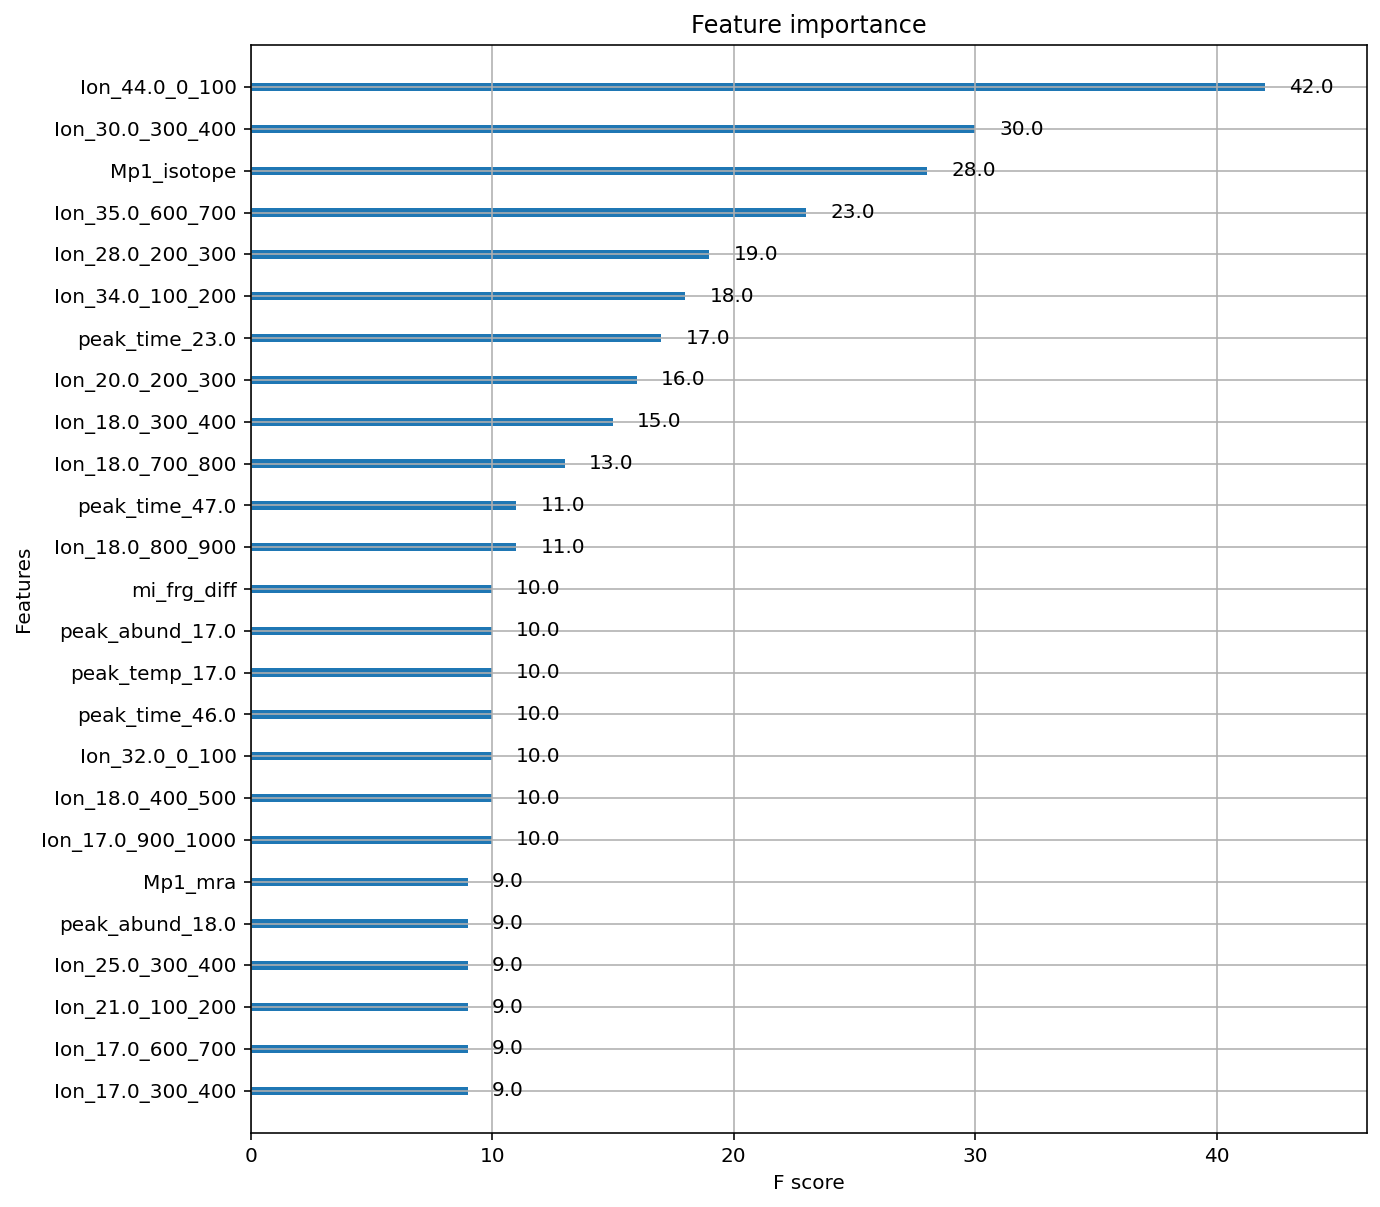

LABEL: carbonate


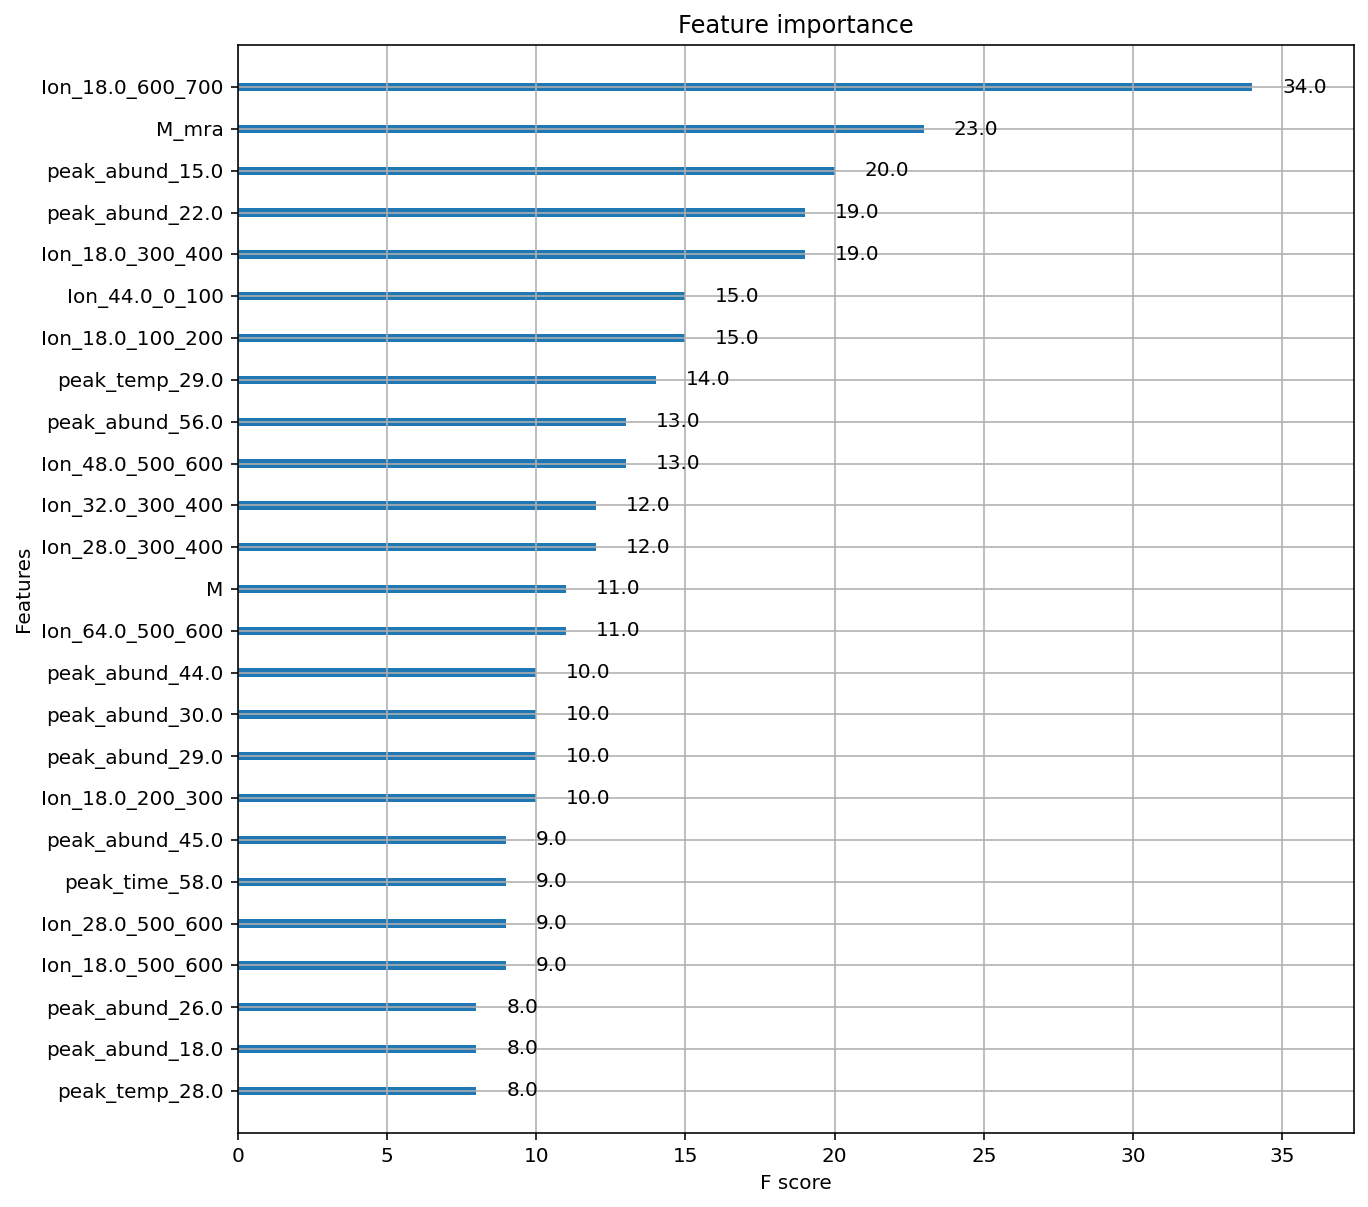

LABEL: chloride


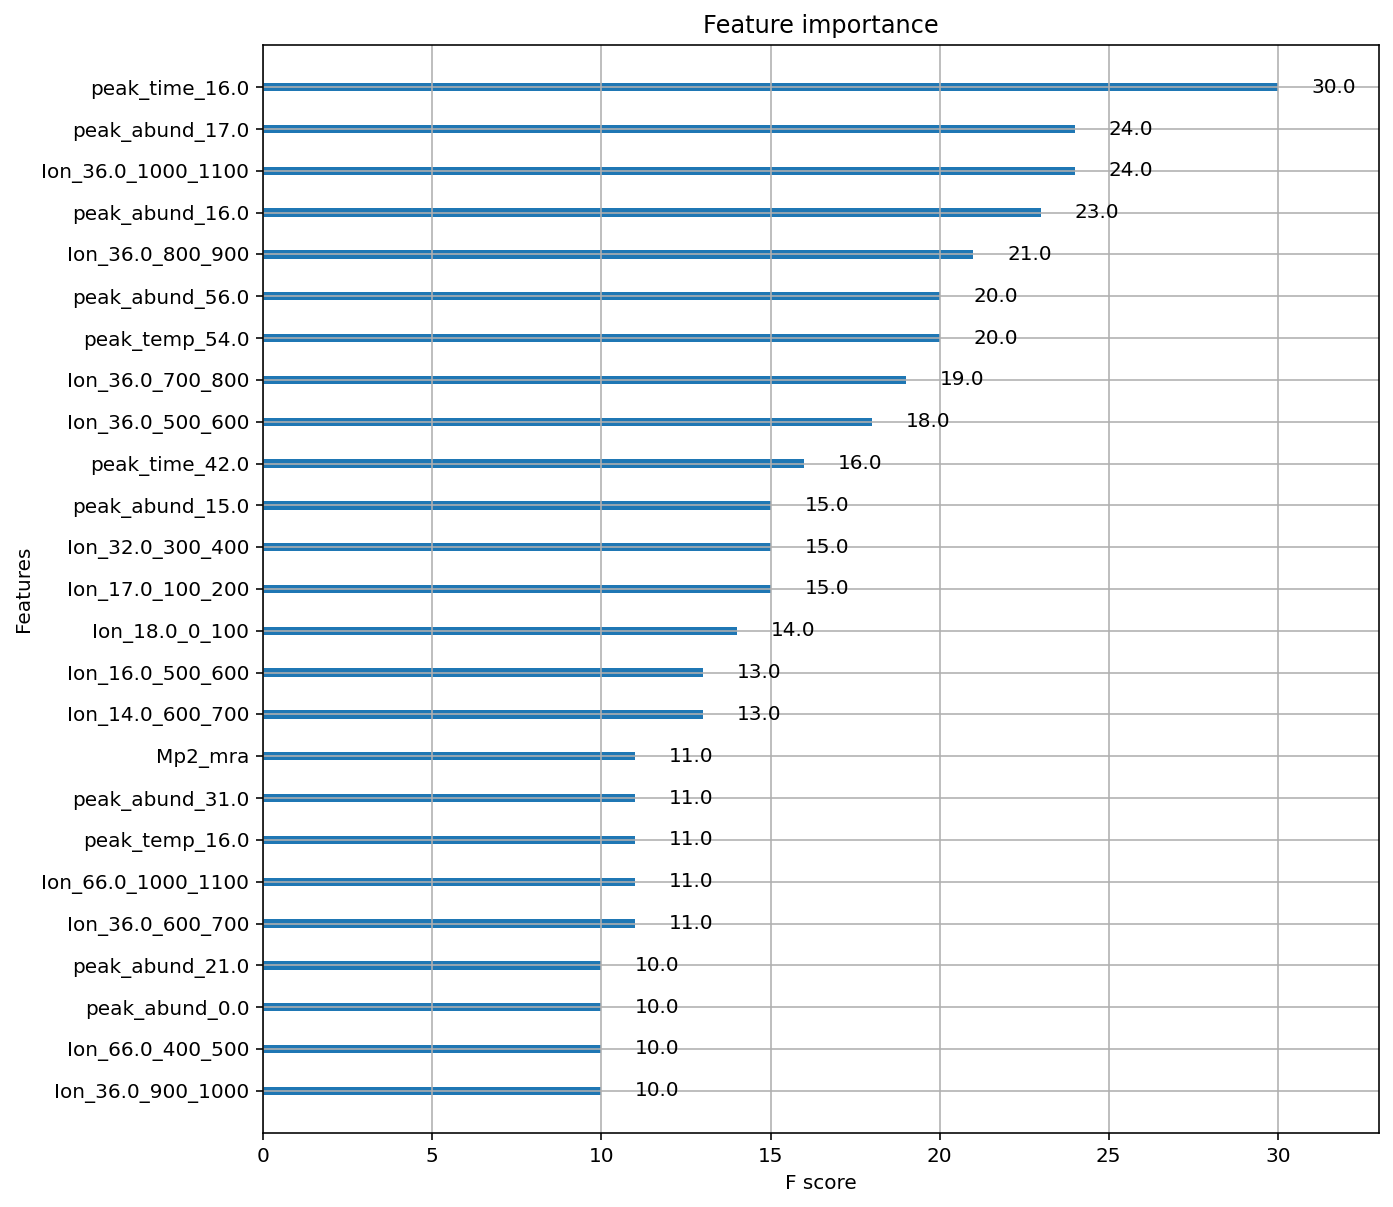

LABEL: iron_oxide


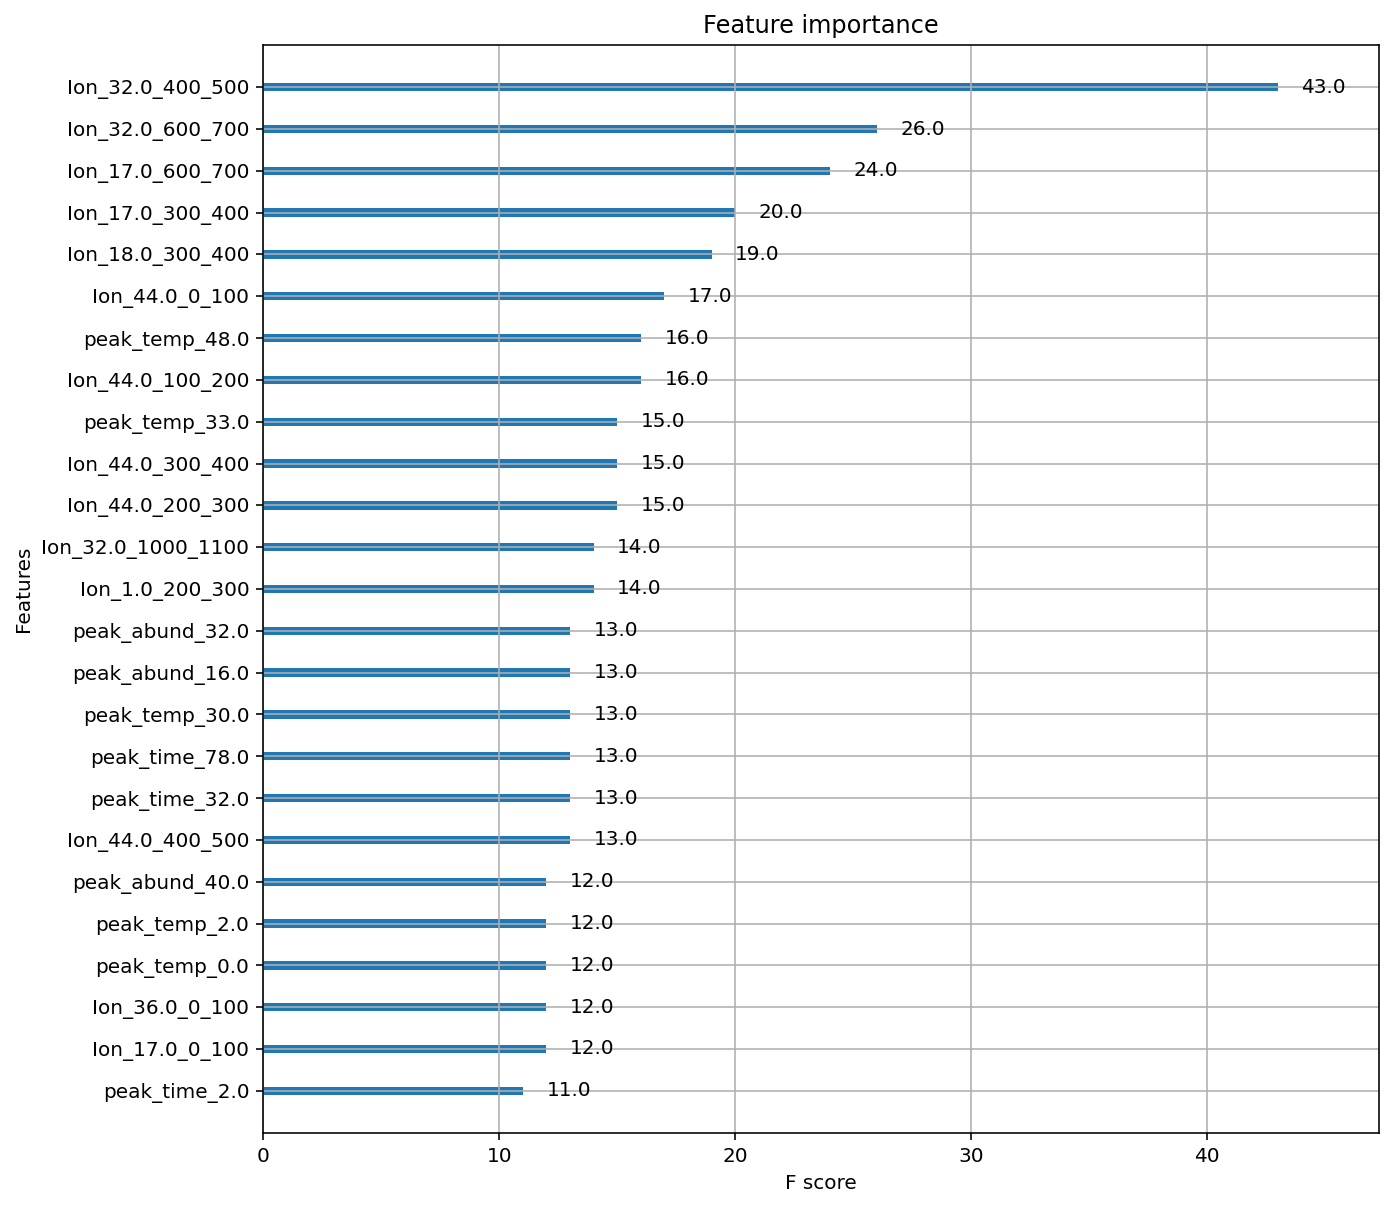

LABEL: oxalate


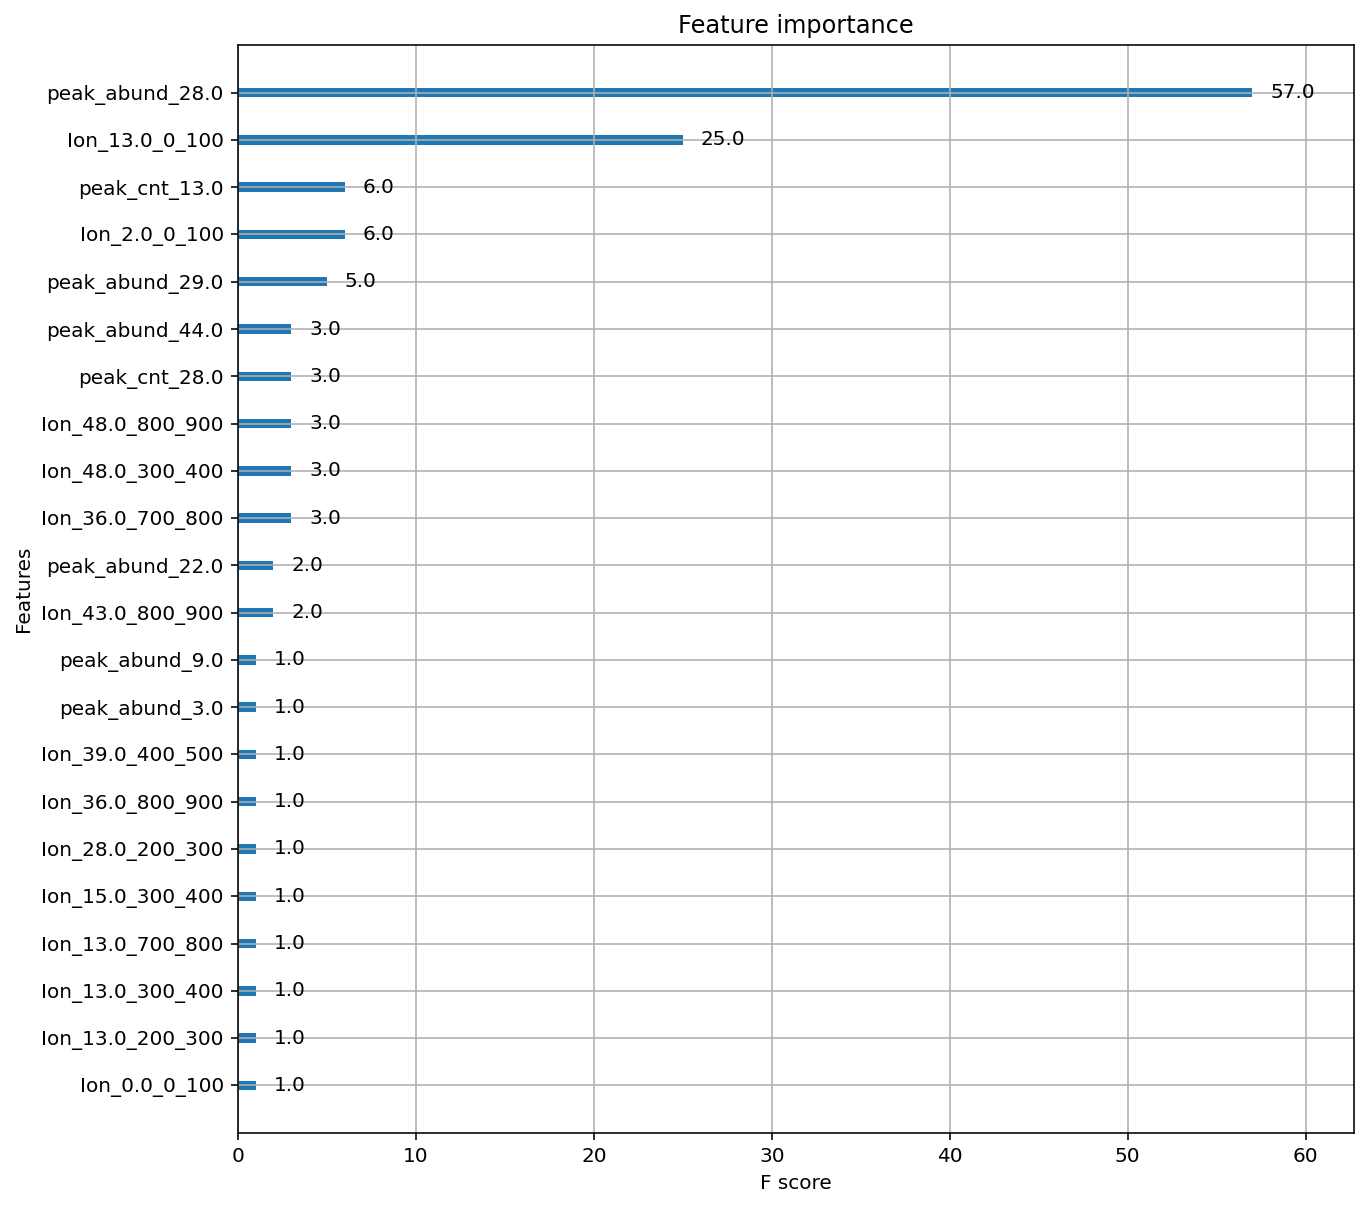

LABEL: oxychlorine


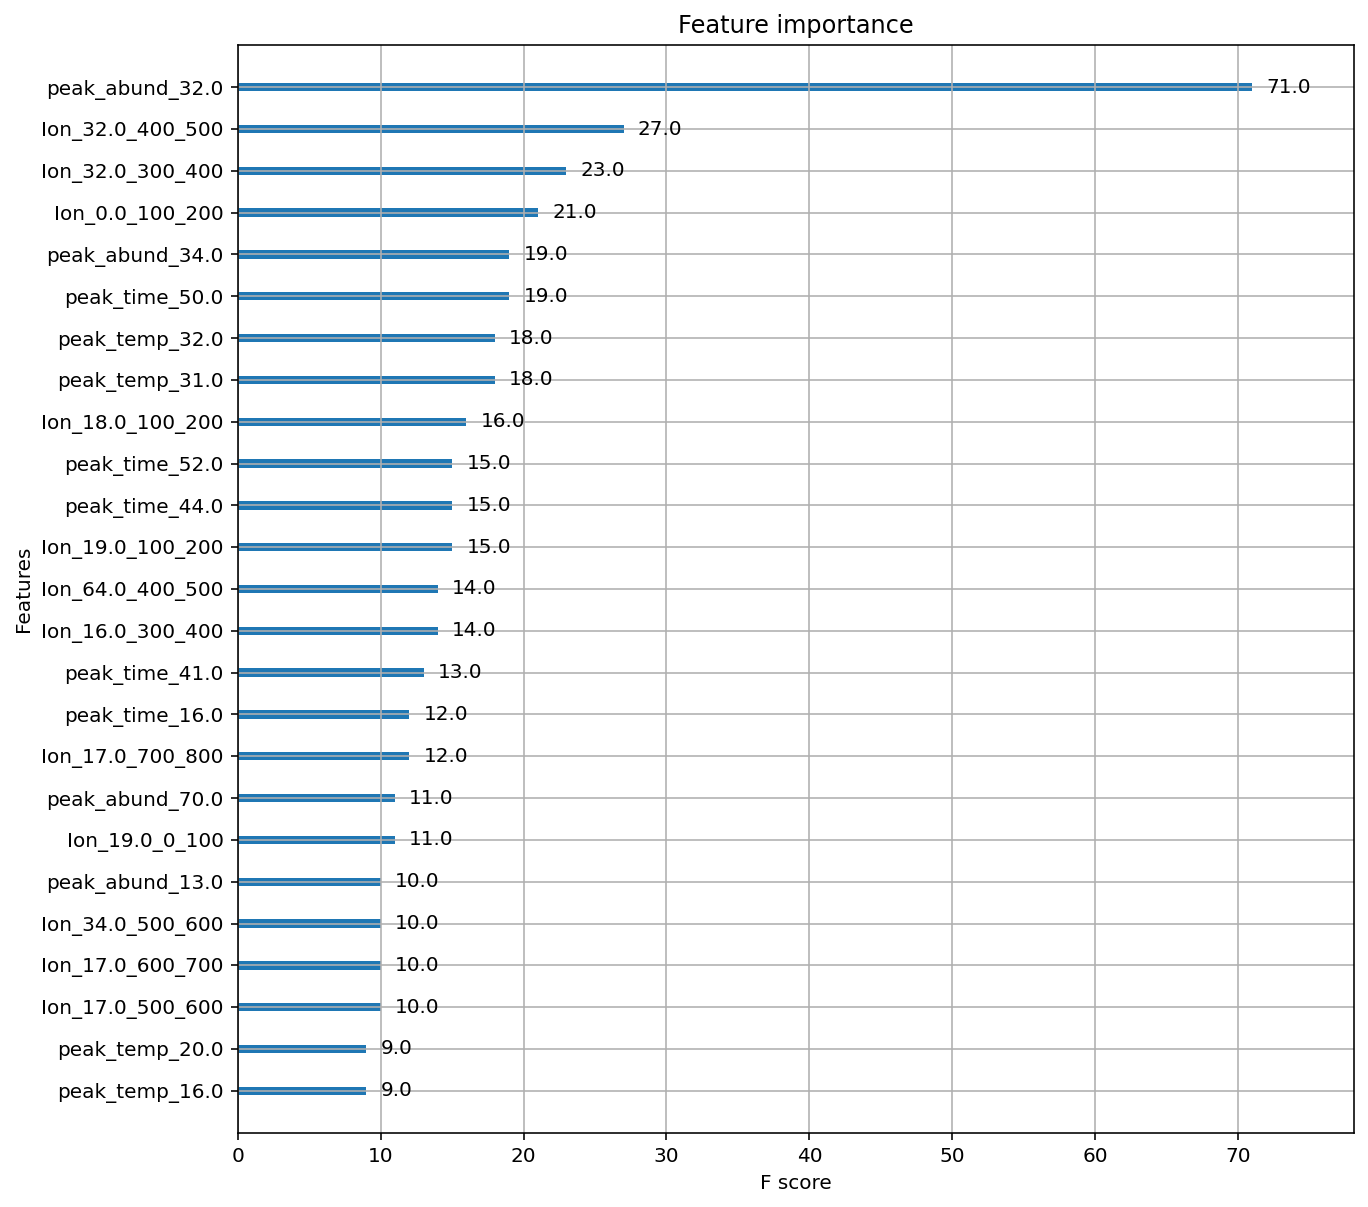

LABEL: phyllosilicate


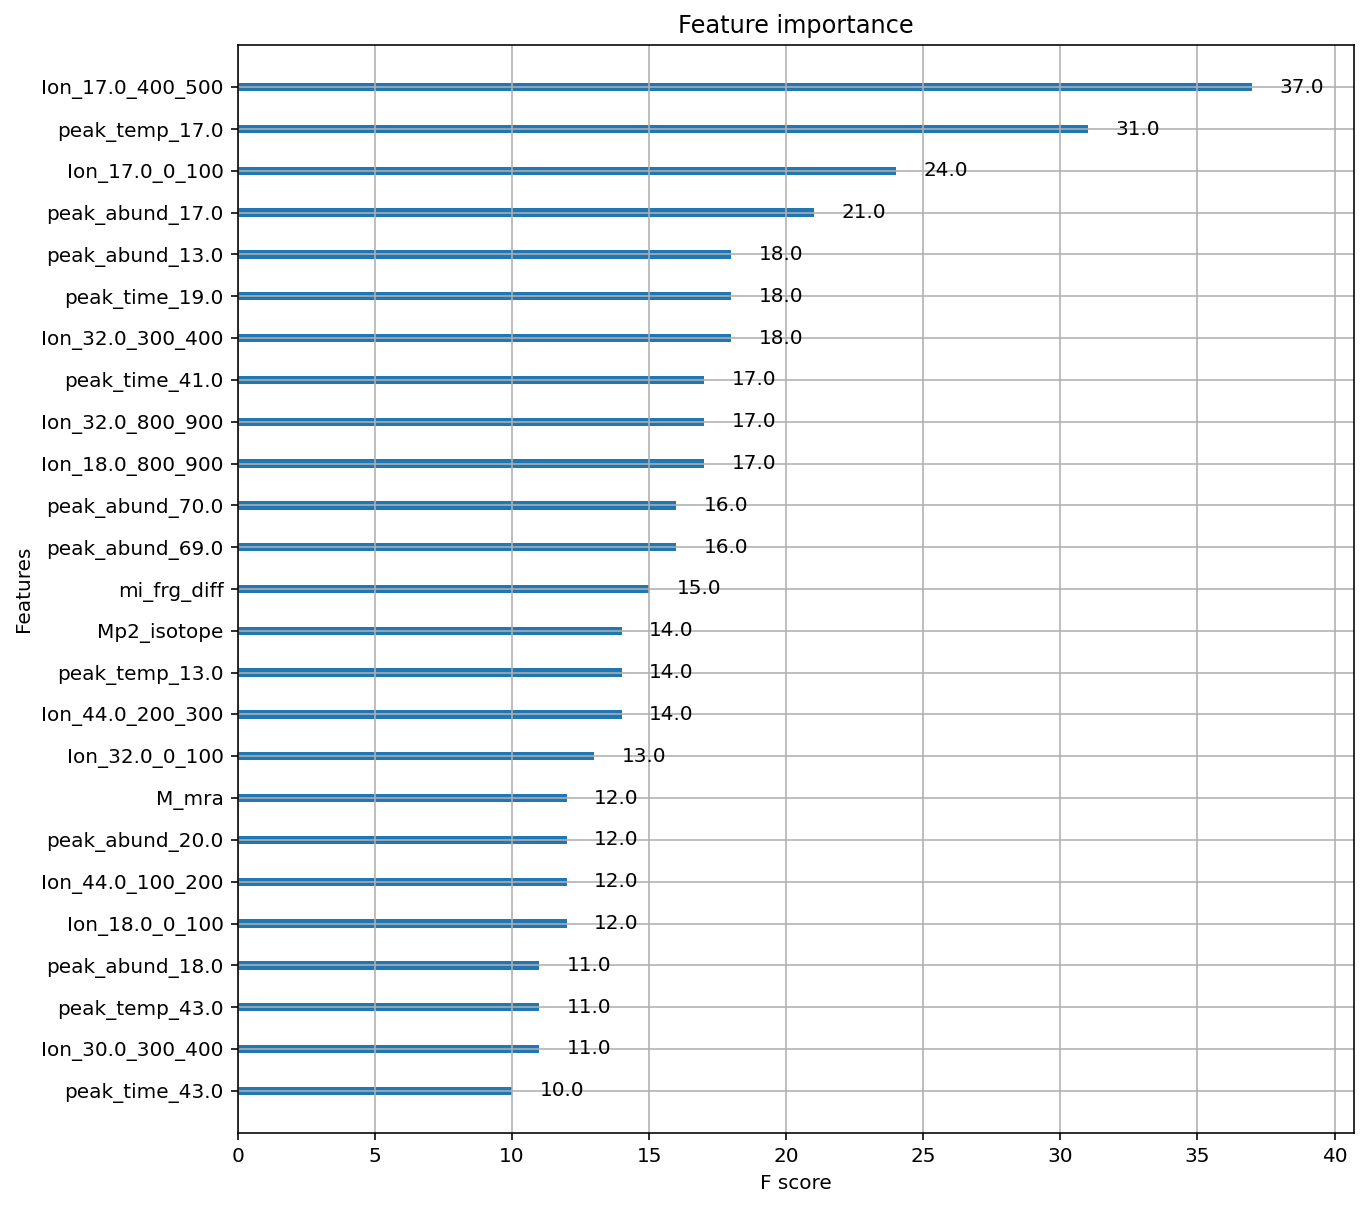

LABEL: silicate


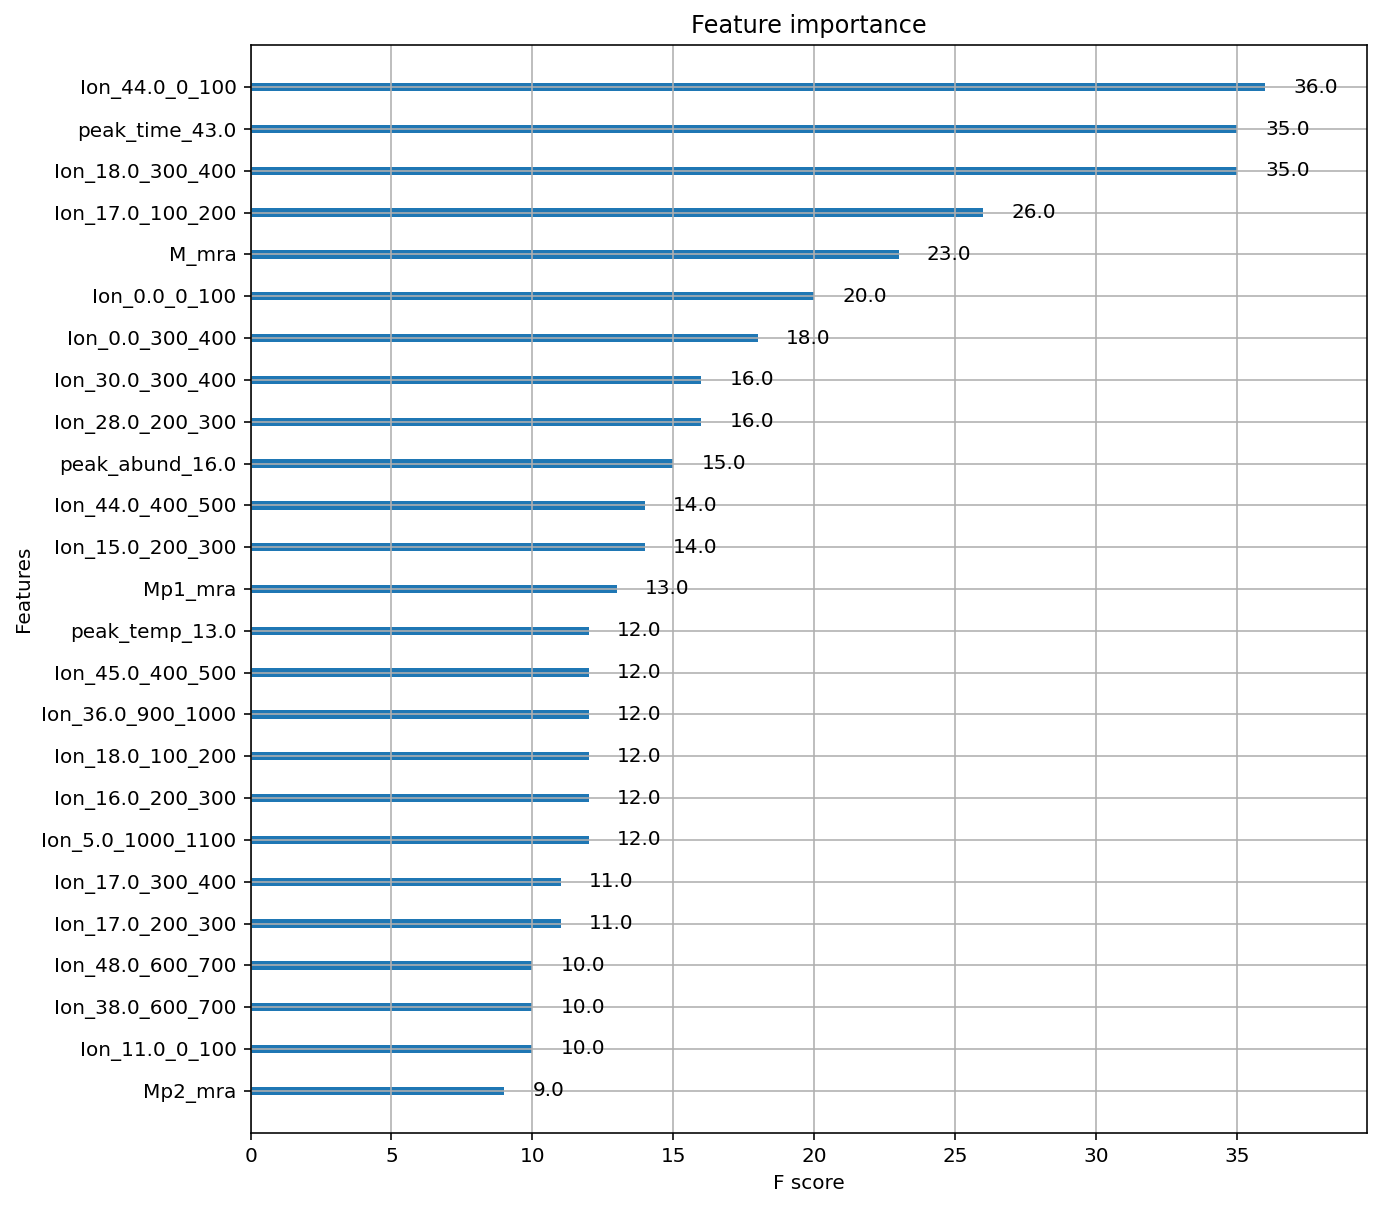

LABEL: sulfate


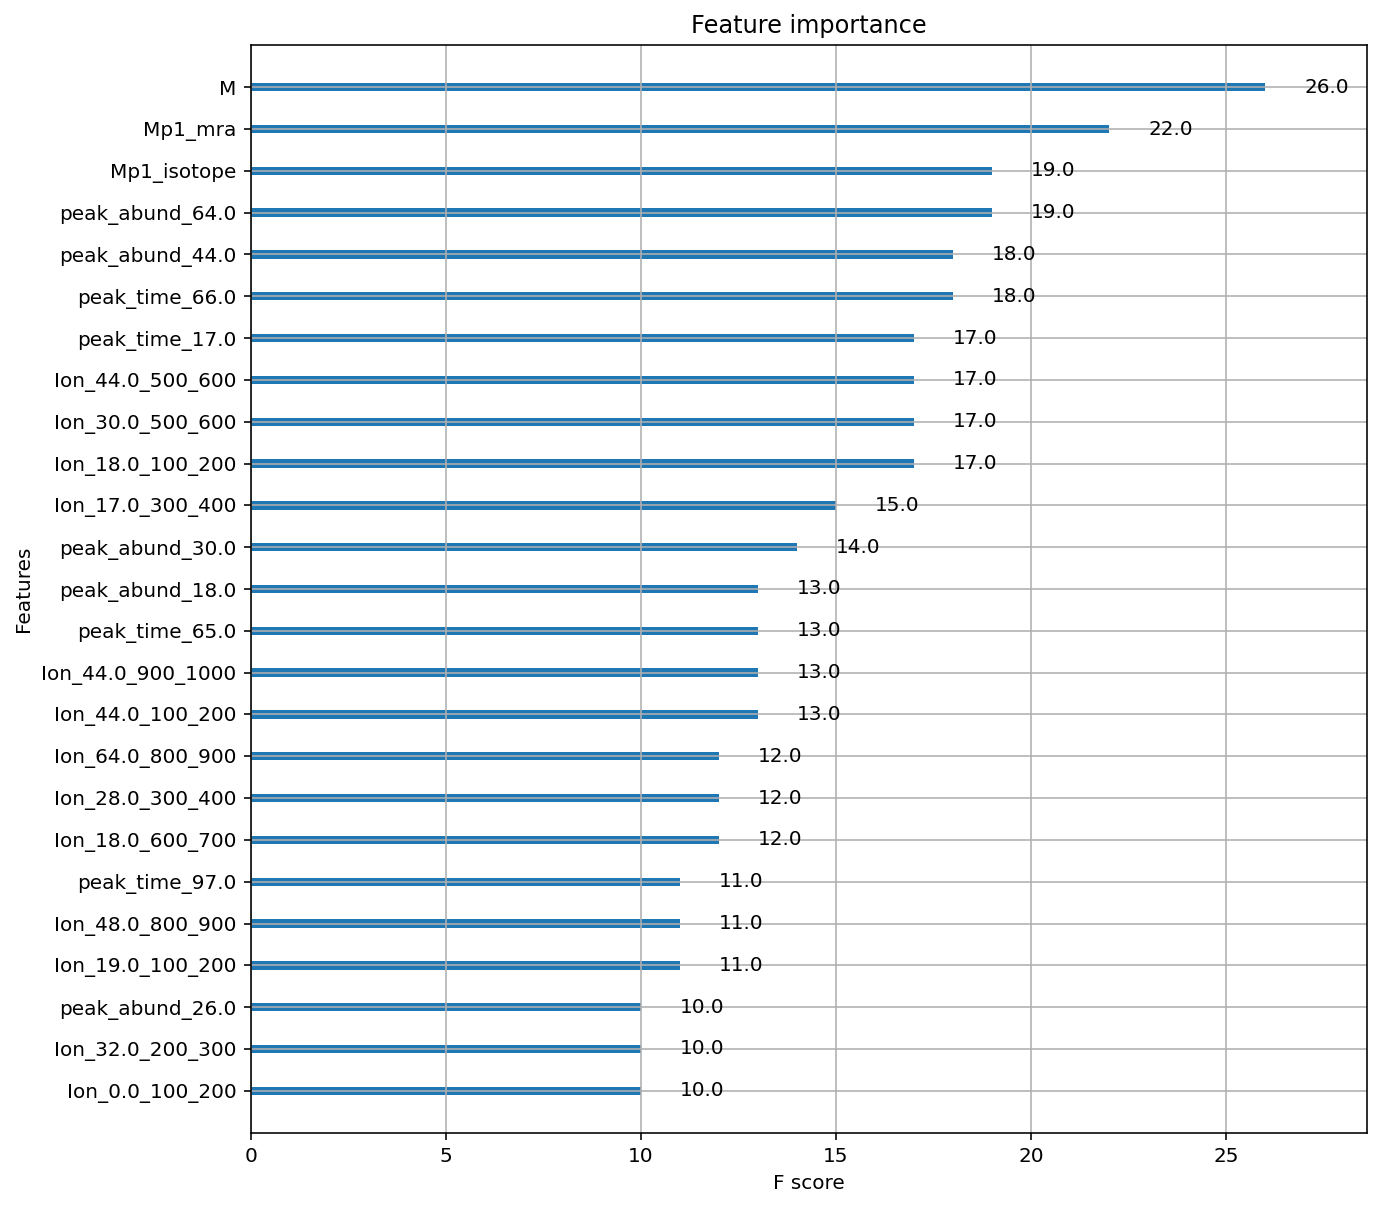

LABEL: sulfide


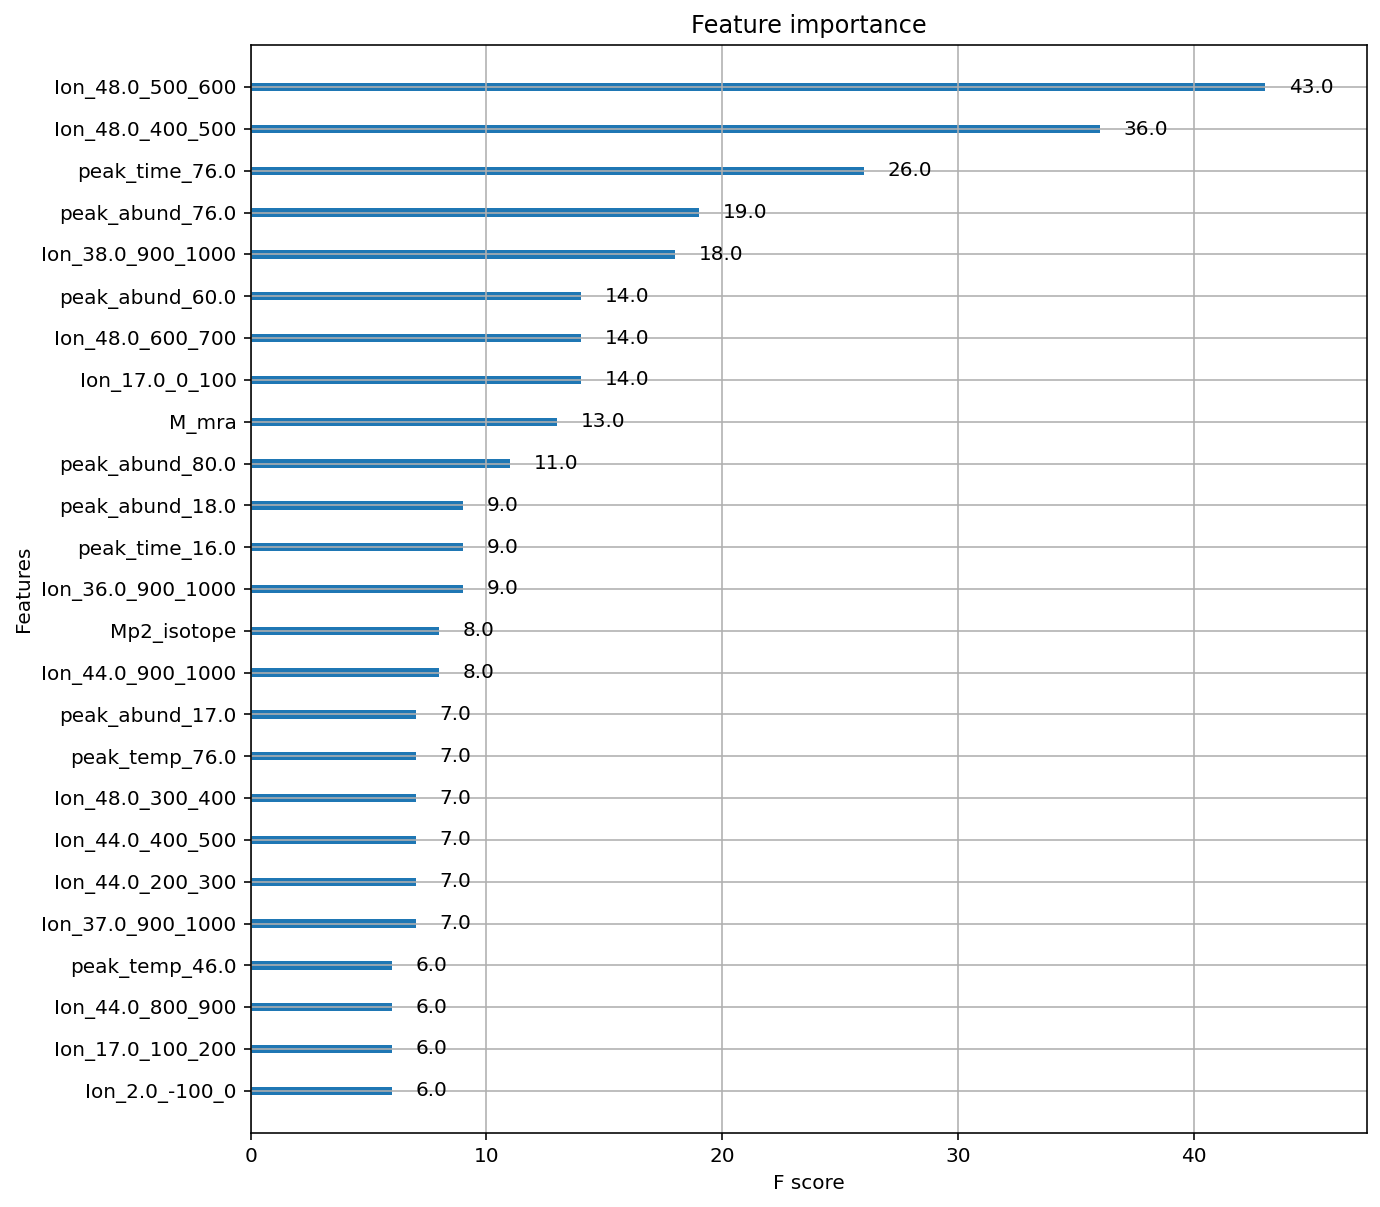


Average Log Loss: 0.1715
Log Loss per Label:
{'basalt': 0.19059170584404792, 'carbonate': 0.12573795113879155, 'chloride': 0.20230934622104554, 'iron_oxide': 0.24248385070333162, 'oxalate': 0.012635378048959773, 'oxychlorine': 0.1682444882529693, 'phyllosilicate': 0.23600526988812556, 'silicate': 0.23696801150142655, 'sulfate': 0.22524060744307764, 'sulfide': 0.07430298441796876}


In [98]:
train_cv_loss_XGB_spectra, submission_XGB_tempb_spectra_opt = training.train_tbl(
    df_train='combo_maxabund_peaks_slope_spectra',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='combo_maxabund_peaks_slope_spectra_VT',
    model_algo='XGB_opt',
    sub_name='XGB_tempb_spectra_opt'
    )
models_log_loss['XGB_tempb_spectra_opt'] = models_log_loss.index.map(train_cv_loss_XGB_spectra)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

LABEL: basalt


/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


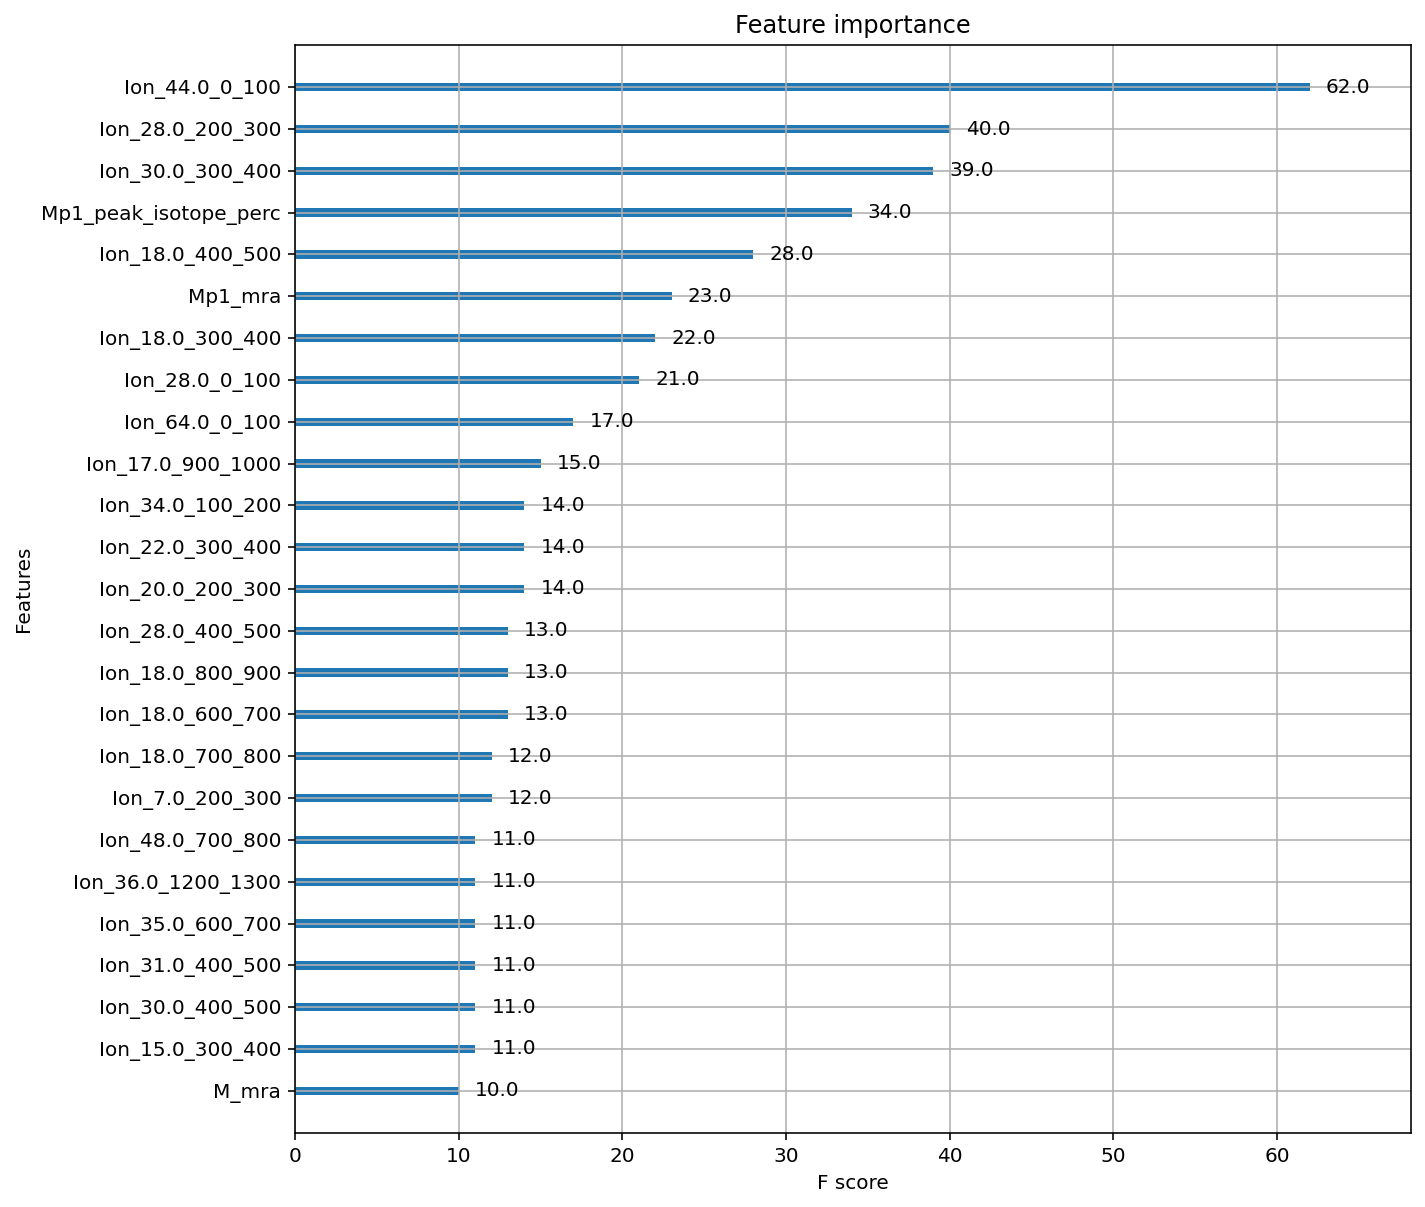

LABEL: carbonate


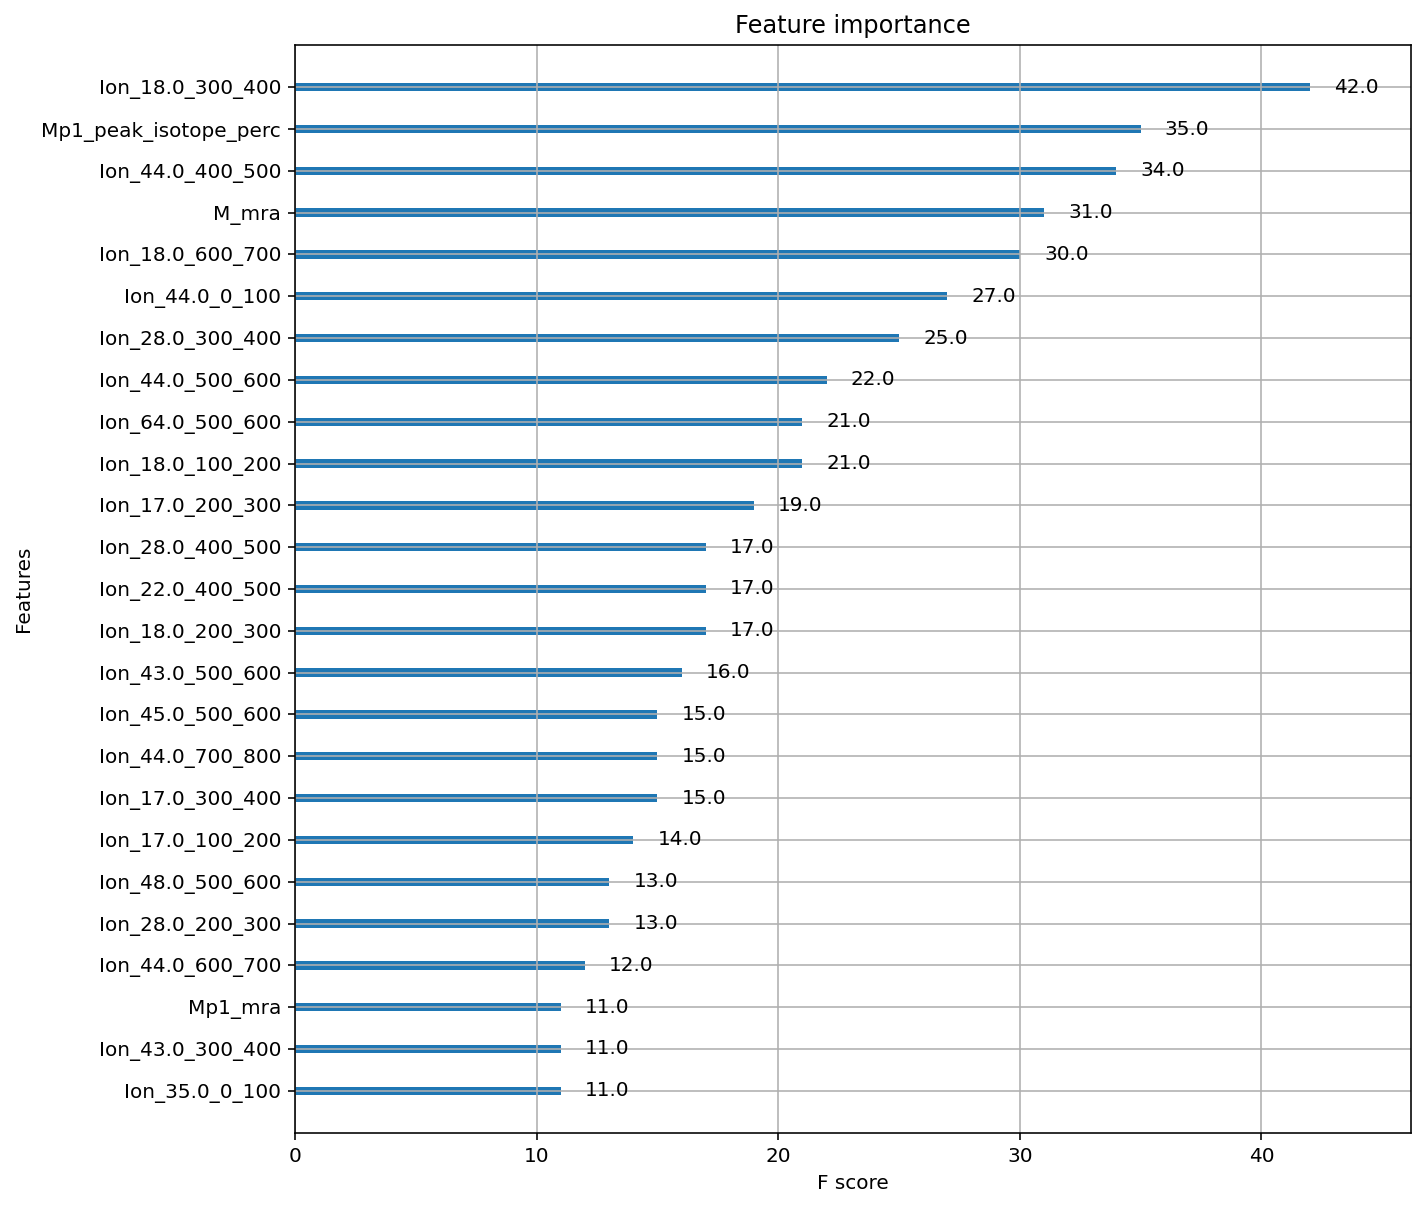

LABEL: chloride


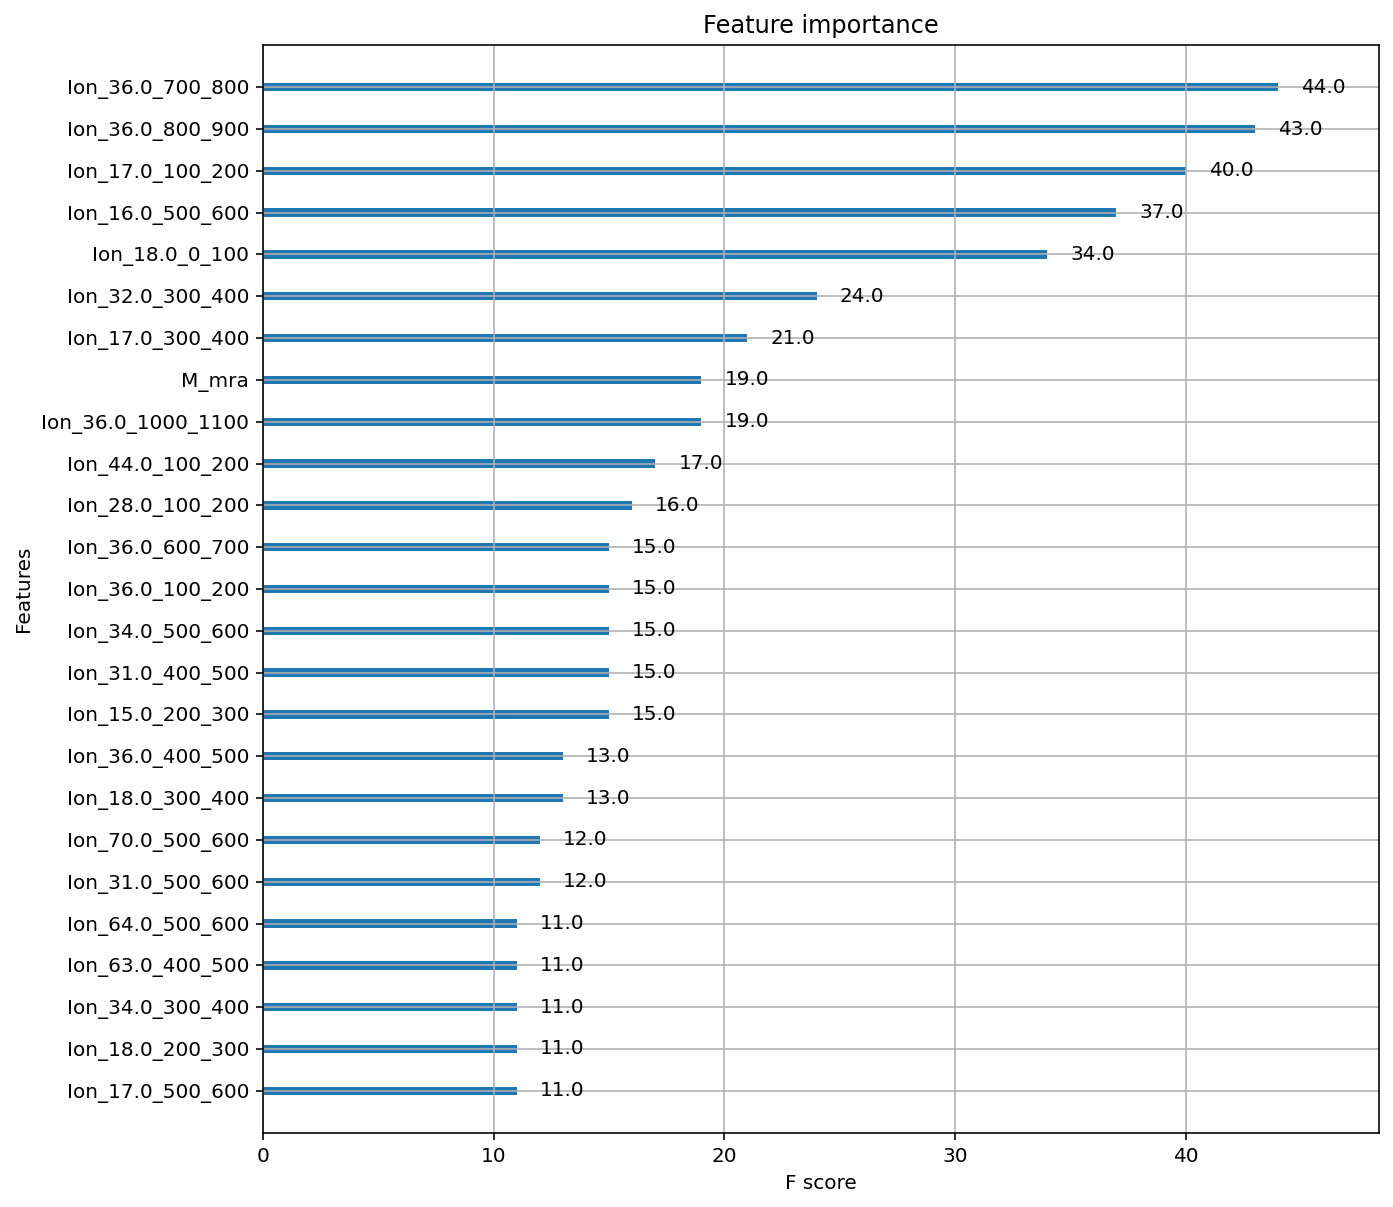

LABEL: iron_oxide


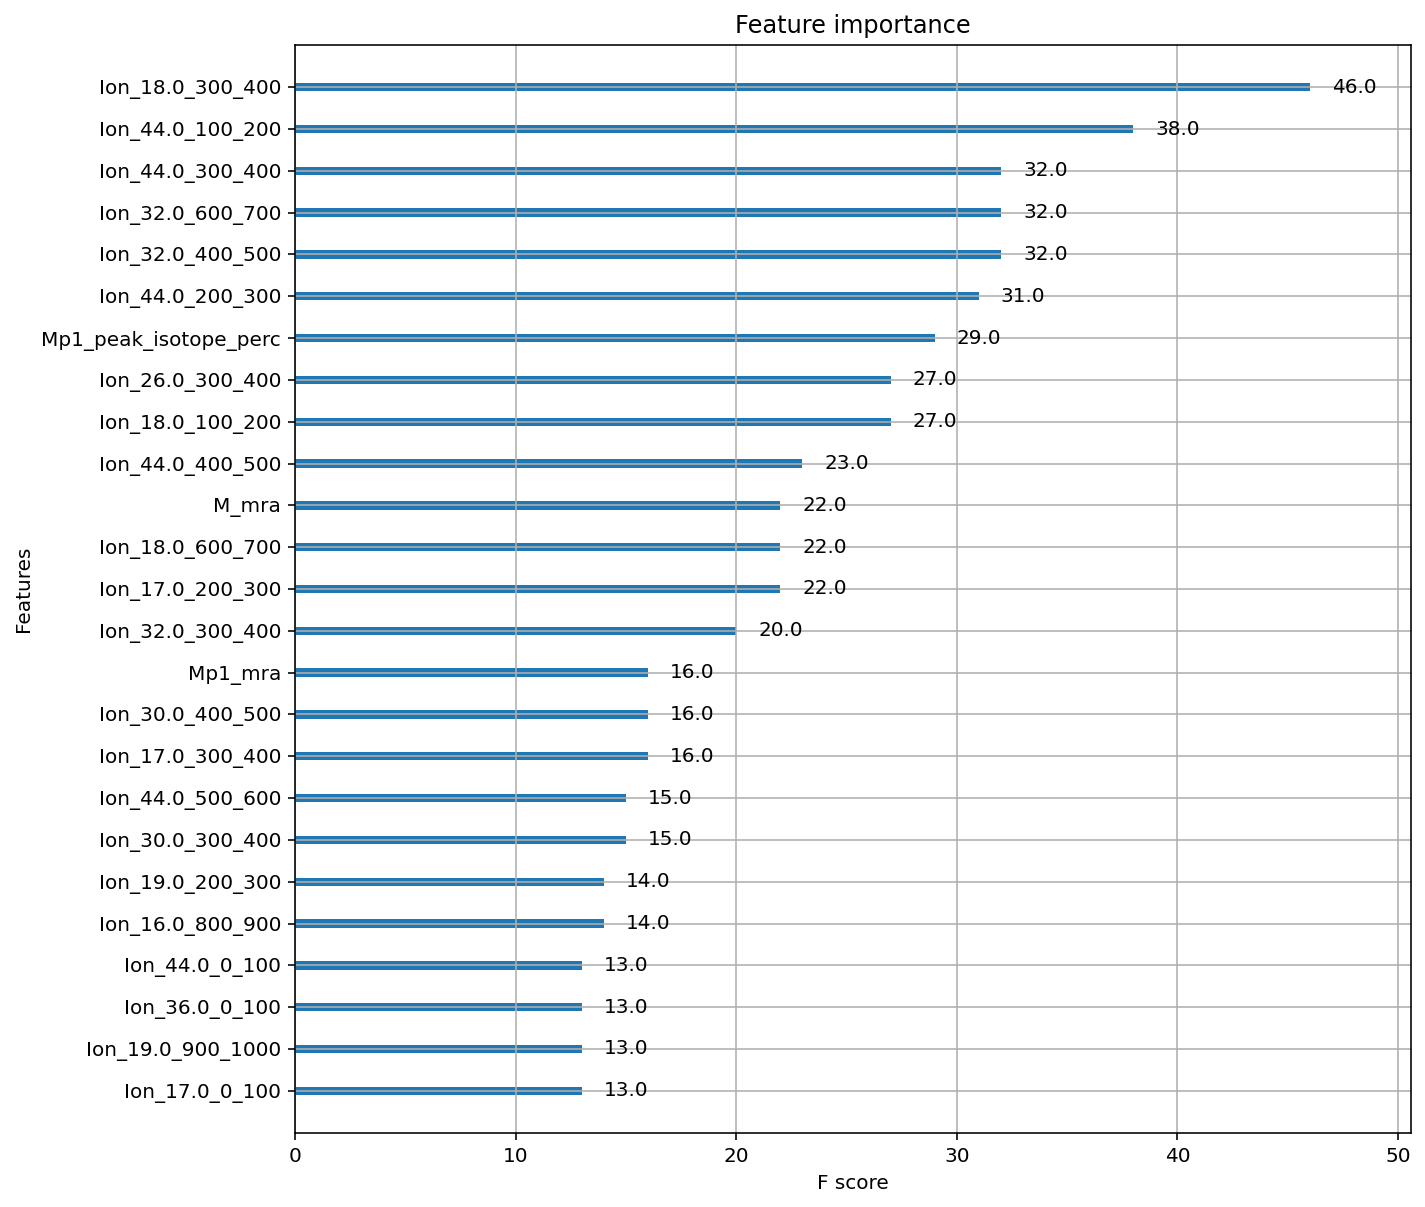

LABEL: oxalate


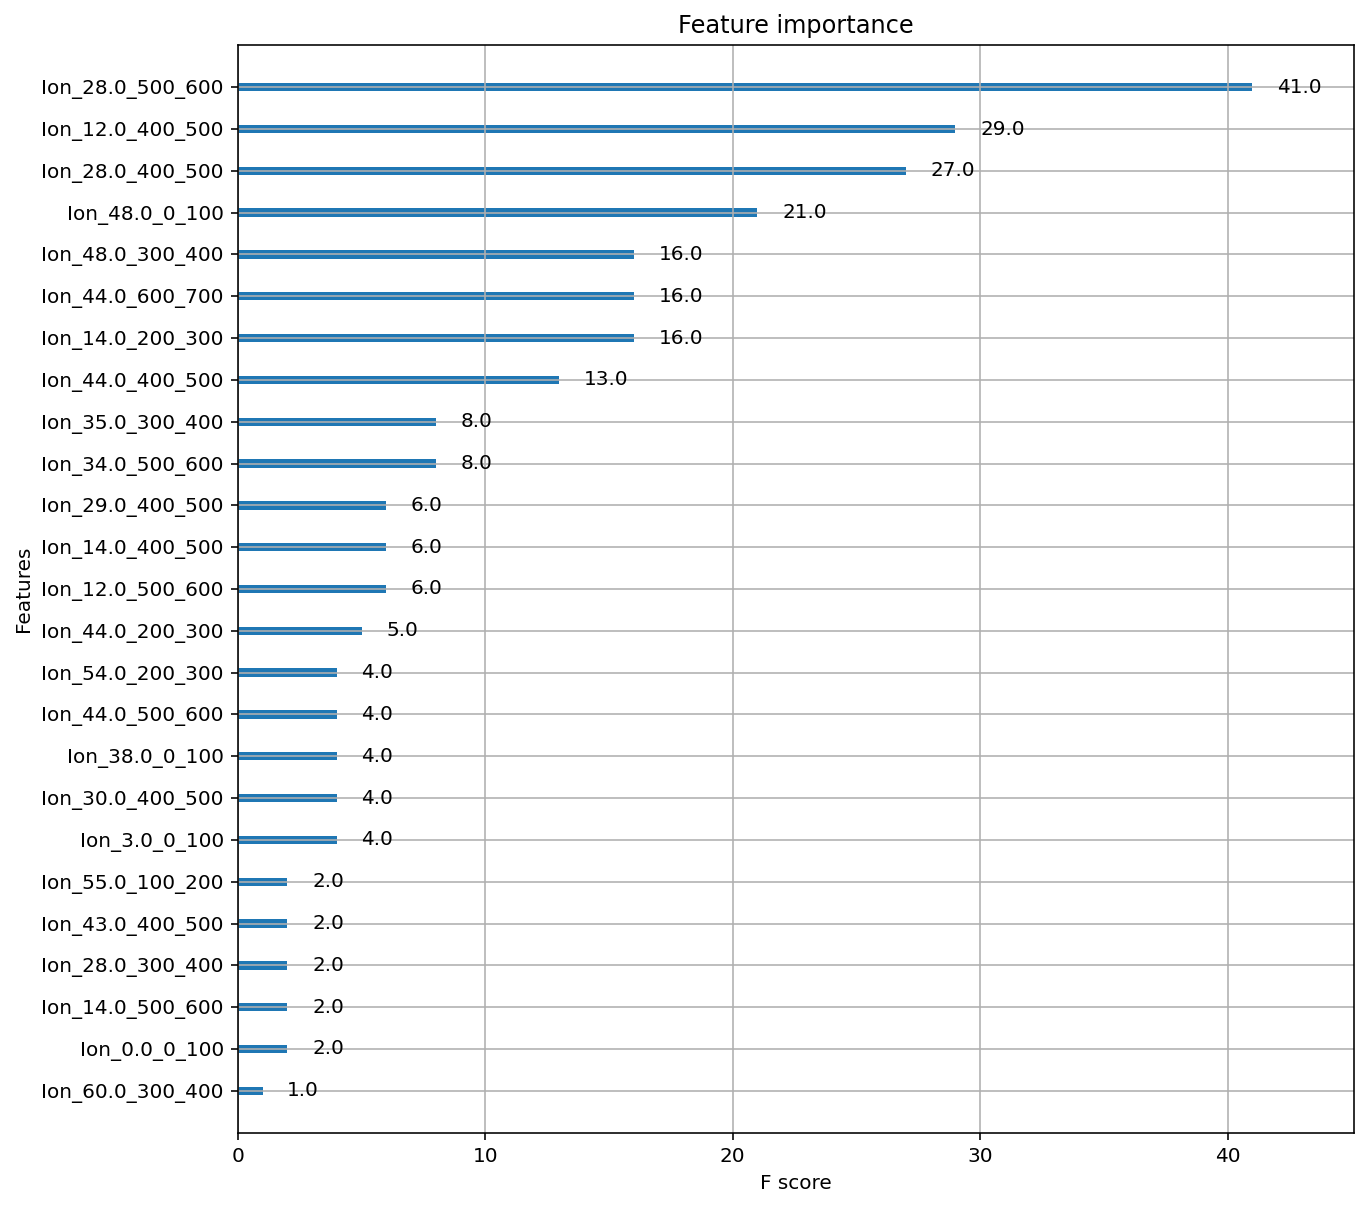

LABEL: oxychlorine


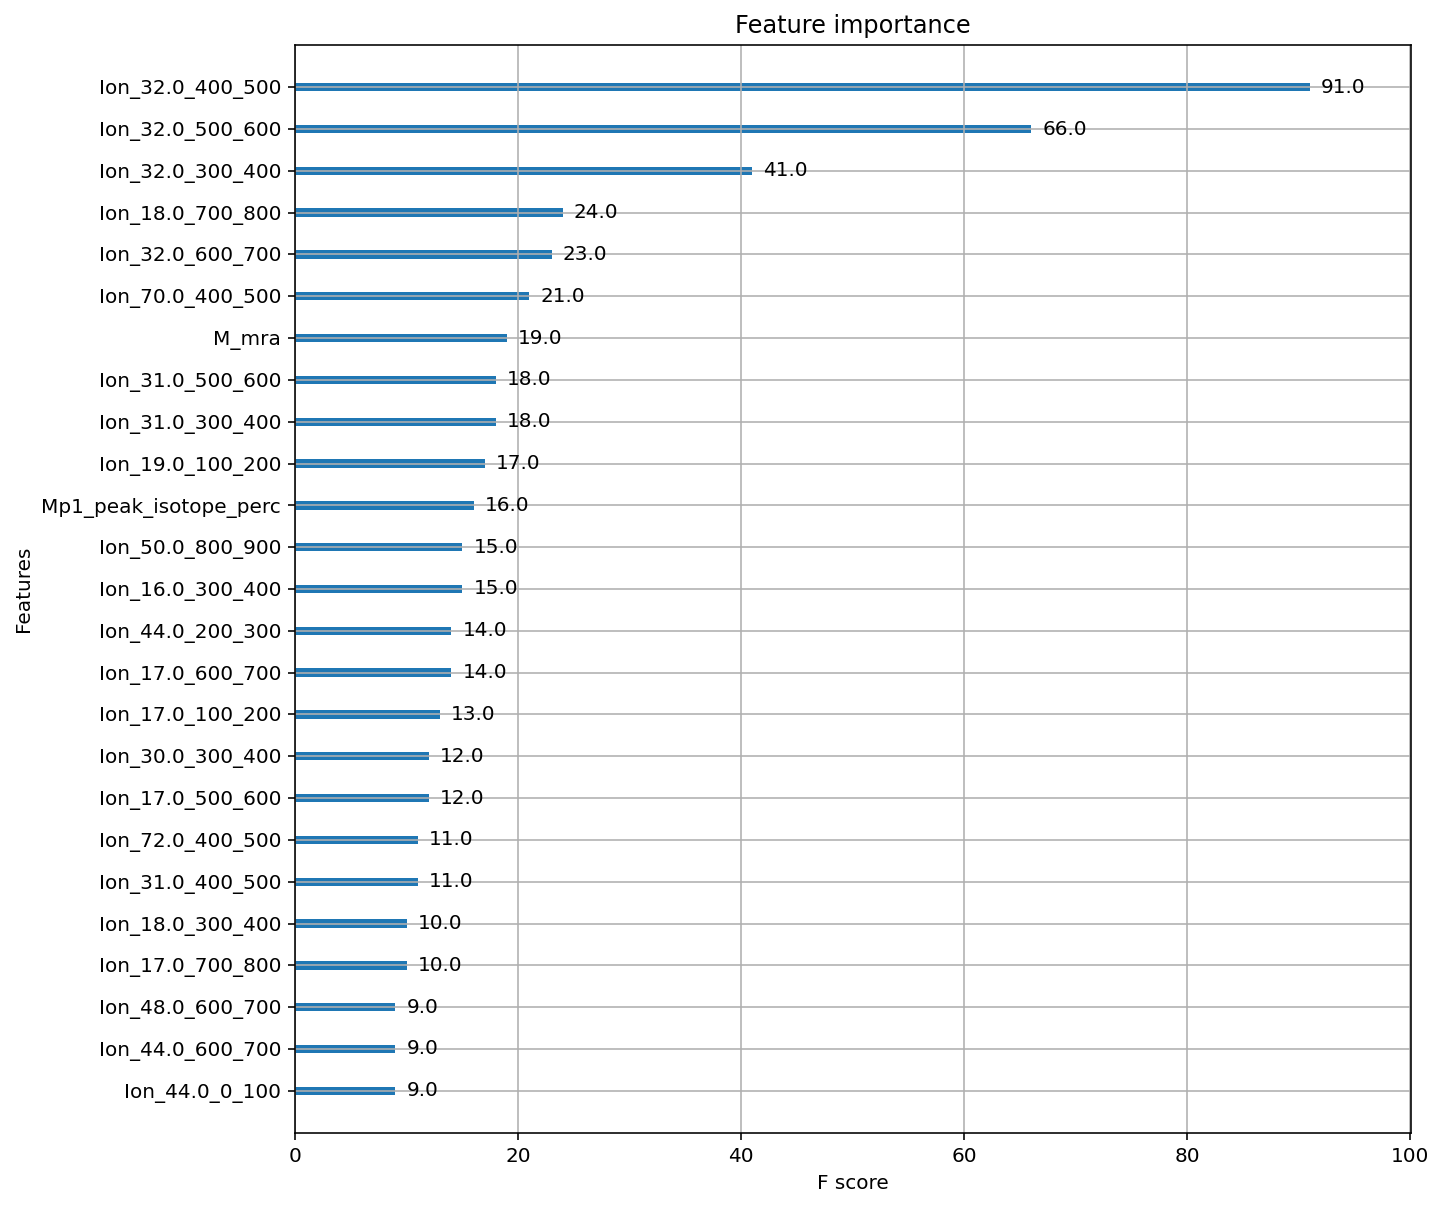

LABEL: phyllosilicate


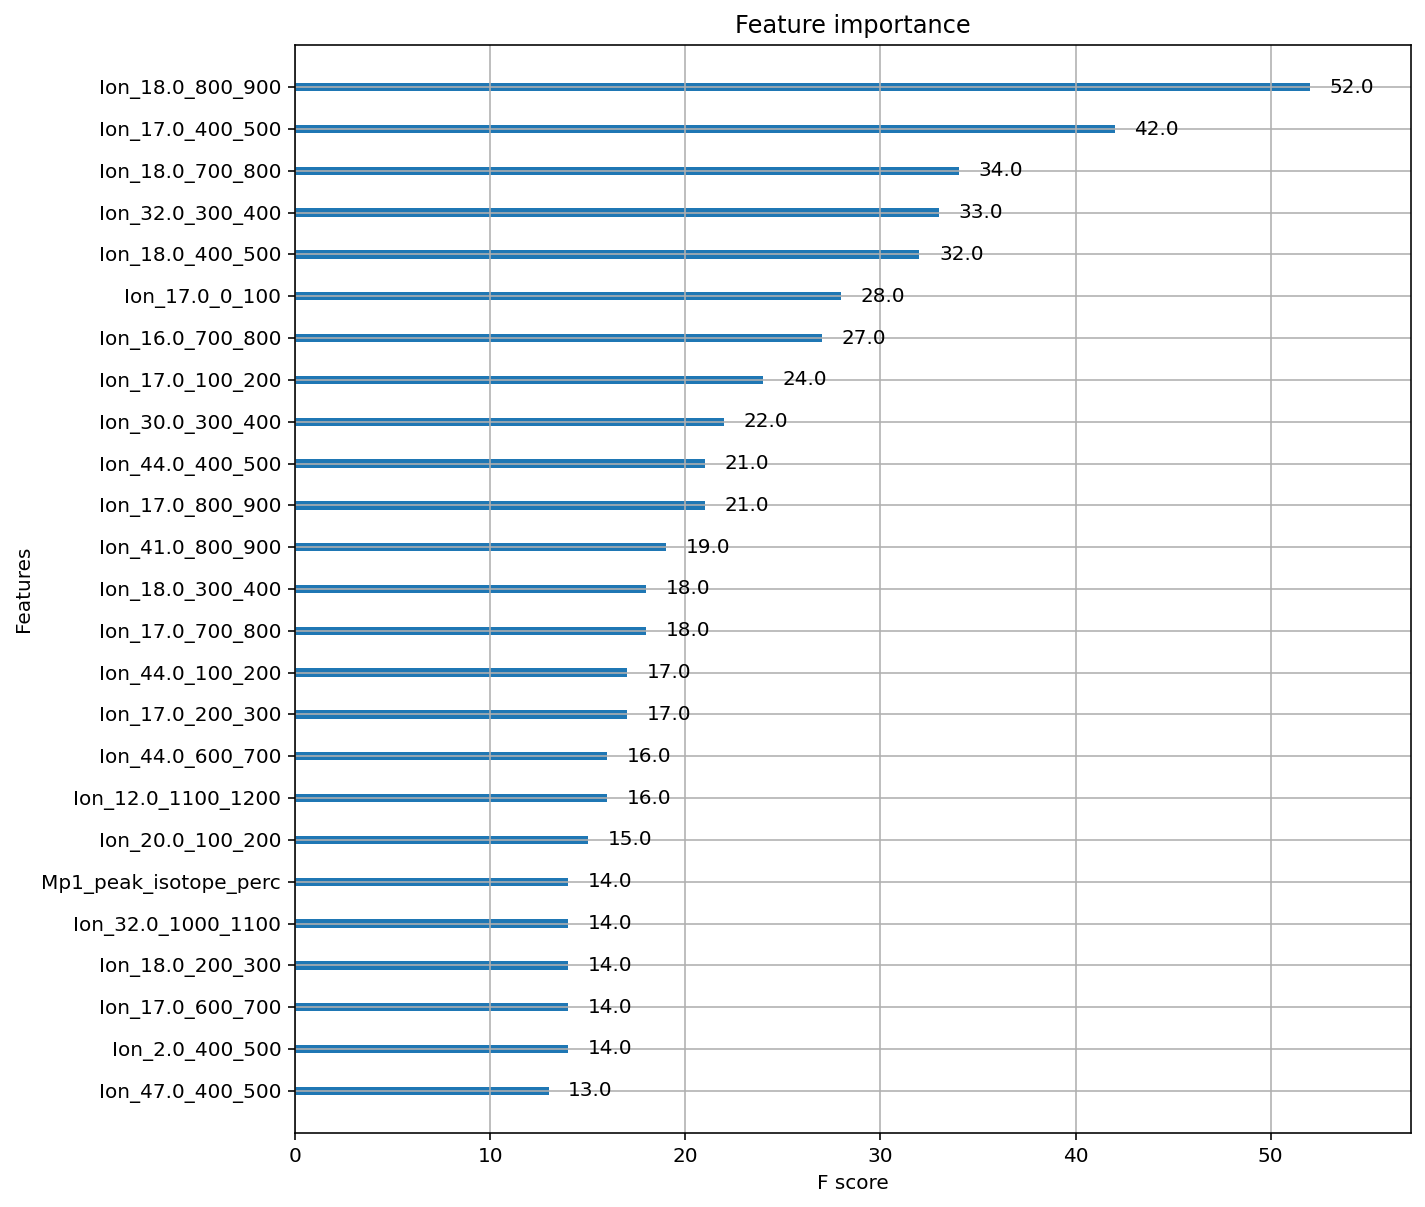

LABEL: silicate


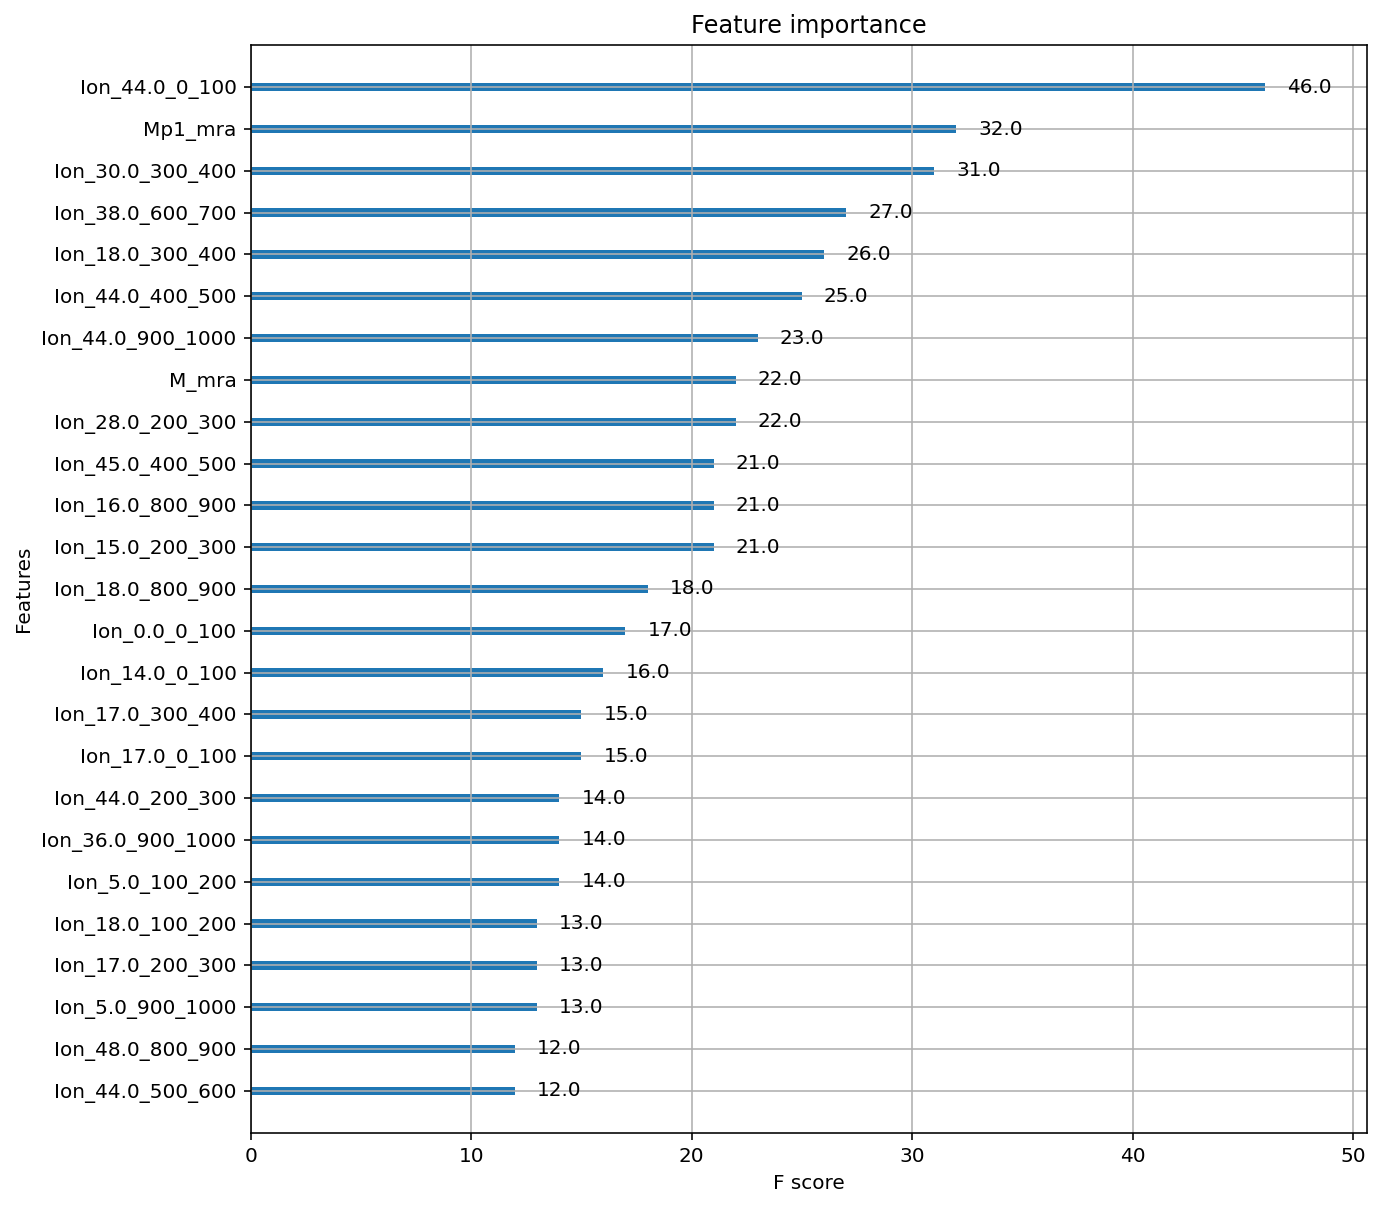

LABEL: sulfate


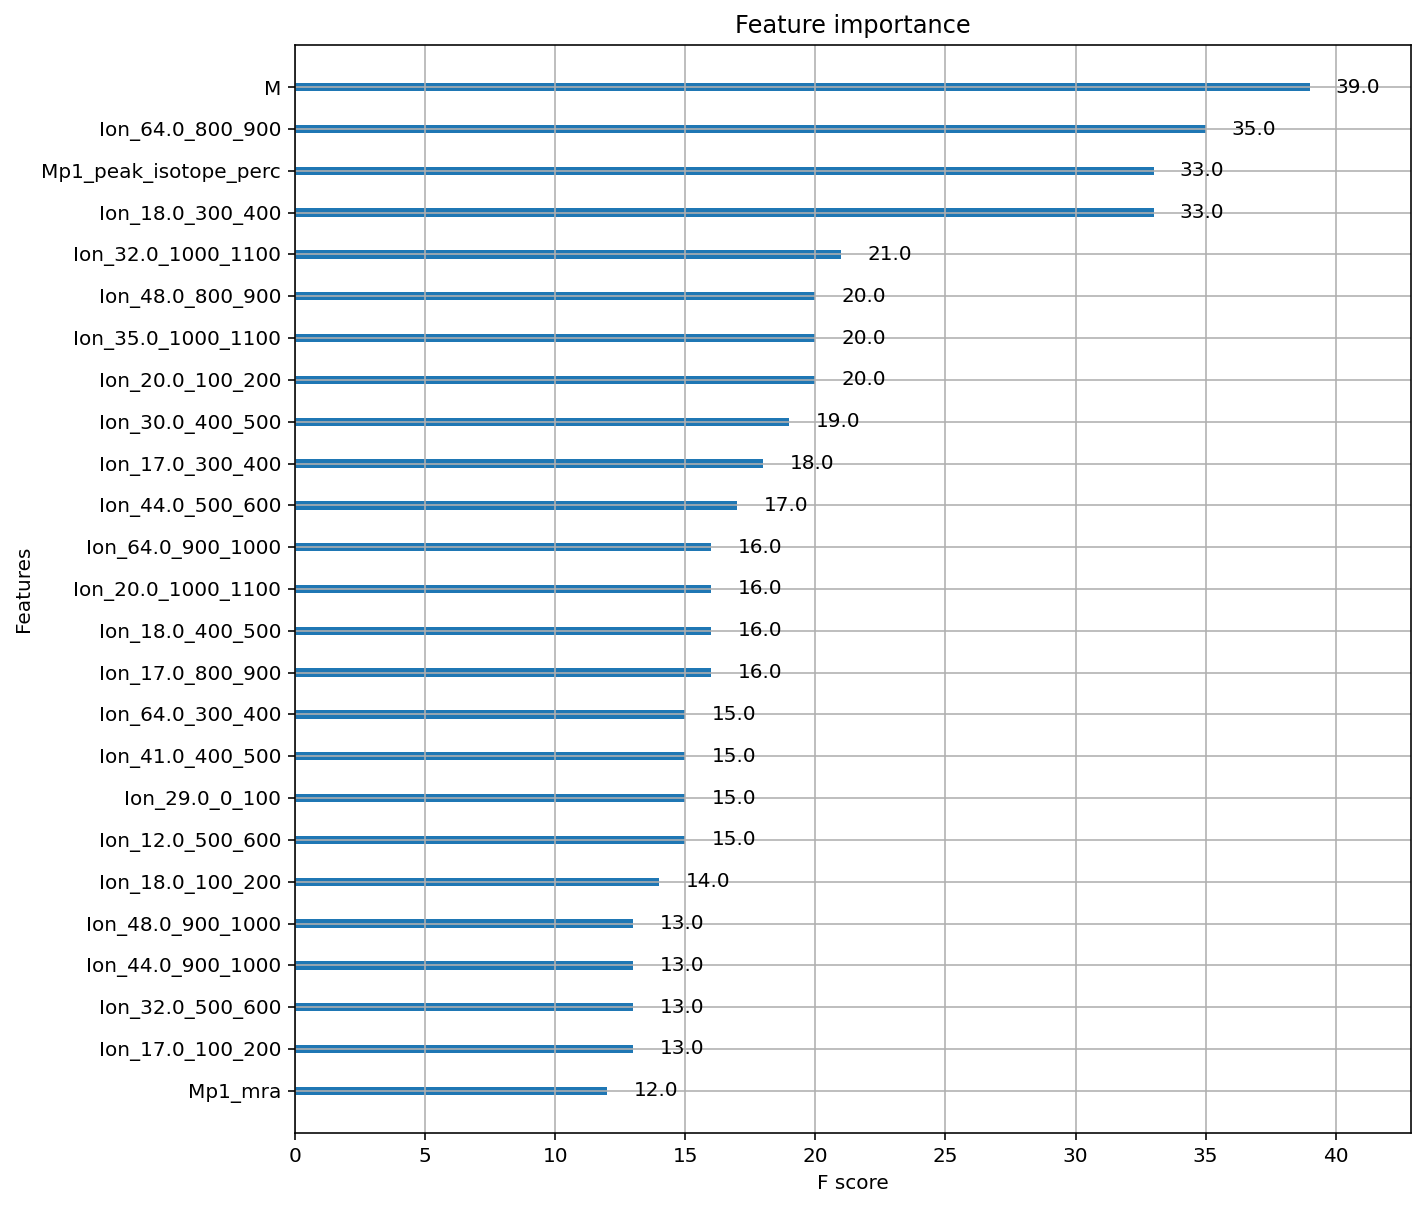

LABEL: sulfide


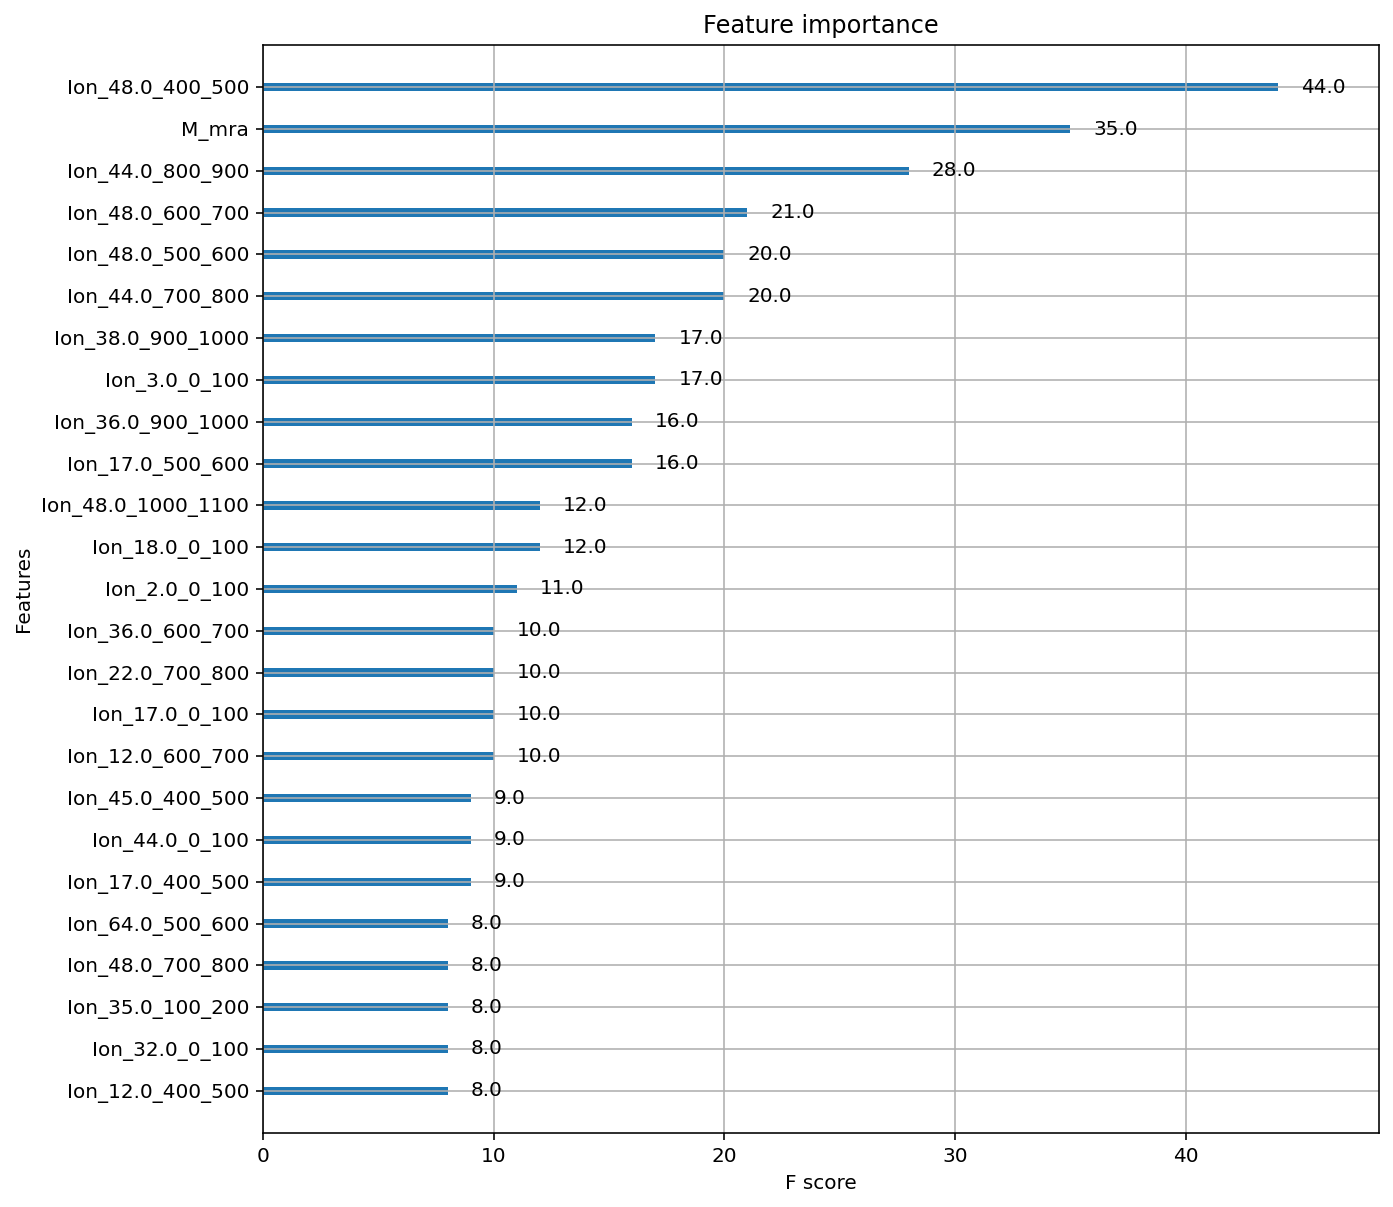


Average Log Loss: 0.1492
Log Loss per Label:
{'basalt': 0.1583013395252921, 'carbonate': 0.09753238448700083, 'chloride': 0.1662865609148681, 'iron_oxide': 0.20821211507225845, 'oxalate': 0.016208049944925782, 'oxychlorine': 0.15815050778270706, 'phyllosilicate': 0.24340647742486085, 'silicate': 0.19205217866847285, 'sulfate': 0.1731007783928667, 'sulfide': 0.07881859170146491}


In [93]:
train_cv_loss_XGB_spectra_trvl, submission_XGB_tempb_spectra_opt_trvl = training.train_tbl(
    df_train='combo_maxabund_peaks_slope_spectra_trvl',
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test='combo_maxabund_peaks_slope_spectra_VT',
    model_algo='XGB_opt',
    sub_name='XGB_tempb_spectra_opt_trvl'
    )
models_log_loss['XGB_tempb_spectra_opt_trvl'] = models_log_loss.index.map(train_cv_loss_XGB_spectra_trvl)

## XGBopt - `combo_maxabund_mzstats`

In [105]:
train_cv_loss_XGB_stats, submission_XGB_tempb_stats_opt = training.train_tbl(
    df_train='combo_maxabund_stats',
    df_labels=train_labels,
    target_list=target_labels_list,
    df_test='combo_maxabund_stats_VT',
    model_algo='XGB_opt',
    sub_name='XGB_tempb_stats_opt'
    )
models_log_loss['XGB_tempb_stats_opt'] = models_log_loss.index.map(train_cv_loss_XGB_stats)

/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/Users/itacdonev/opt/miniconda3/envs/nasamars/lib/python3.9/s

AssertionError: 

In [ ]:
train_cv_loss_XGB_stats_trvl, submission_XGB_tempb_stats_opt_trvl = training.train_tbl(
    df_train='combo_maxabund_stats_trvl',
    df_labels=trvl_labels,
    target_list=target_labels_list,
    df_test='combo_maxabund_stats_VT',
    model_algo='XGB_opt',
    sub_name='XGB_tempb_stats_opt_trvl'
    )
models_log_loss['XGB_tempb_stats_opt_trvl'] = models_log_loss.index.map(train_cv_loss_XGB_stats_trvl)

# MODEL SUMMARY

In [99]:
models_log_loss.to_csv(os.path.join(config.MODELS_DIR + 'models_log_loss.csv'))

In [100]:
models_log_loss.style.highlight_min(axis=1, 
                                    props='color:darkblue; background-color:lightblue;')

,LR_reg,LR_reg_trvl,XGB_opt,XGB_opt_trvl,SVC,SVC_trvl,XGB_tempb_peaks_opt,XGB_tempb_peaks_opt_trvl,XGB_tempb_peaks_slope_opt,XGB_tempb_peaks_slope_opt_trvl,XGB_tempb_peaks_slope_topi_opt,XGB_tempb_peaks_slope_topi_opt_trvl,XGB,XGB_trvl,XGB_opt_area,XGB_tempb_peaks_slope_area_opt_trvla,XGB_opt_area_trvl,XGB_opt_area_filtered,XGB_opt_area_filtered_trvl,XGB_tempb_spectra_opt,XGB_tempb_spectra_opt_trvl
basalt,0.276783,0.261526,0.196651,0.160304,0.250770,0.234185,0.195044,0.149828,0.195206,0.149099,0.195875,0.148373,0.225651,0.175356,0.185858,0.150383,0.162211,0.200084,0.156668,0.190592,0.158301
carbonate,0.261255,0.222921,0.121020,0.092998,0.197203,0.179595,0.127256,0.093019,0.120312,0.092454,0.116315,0.089354,0.132256,0.090430,0.127941,0.094996,0.099055,0.144003,0.116696,0.125738,0.097532
chloride,0.284298,0.258468,0.204338,0.170999,0.280727,0.292588,0.200487,0.166660,0.196333,0.163915,0.196345,0.164192,0.227206,0.186224,0.206976,0.165909,0.169389,0.234127,0.196409,0.202309,0.166287
iron_oxide,0.382470,0.372161,0.226116,0.211045,0.353619,0.360896,0.240083,0.207696,0.241699,0.210999,0.239327,0.210547,0.254578,0.235146,0.244666,0.204197,0.215972,0.240398,0.220381,0.242484,0.208212
oxalate,0.004059,0.004915,0.029273,0.016176,0.007036,0.004126,0.012315,0.014034,0.012315,0.014034,0.012315,0.014034,0.027906,0.017461,0.038971,0.014034,0.022626,0.037423,0.021260,0.012635,0.016208
oxychlorine,0.299150,0.252630,0.194202,0.159757,0.252334,0.233197,0.164855,0.148410,0.165305,0.145322,0.161000,0.146340,0.208509,0.167194,0.213814,0.147921,0.151655,0.206881,0.164335,0.168244,0.158151
phyllosilicate,0.407476,0.411243,0.259516,0.239293,0.364549,0.343262,0.239957,0.228776,0.232456,0.222224,0.236131,0.222547,0.297309,0.257462,0.278486,0.225280,0.247094,0.281252,0.257811,0.236005,0.243406
silicate,0.351685,0.349870,0.233179,0.186742,0.295399,0.270911,0.239320,0.196914,0.232388,0.195516,0.229906,0.195059,0.257565,0.205156,0.243665,0.196120,0.200998,0.251308,0.197959,0.236968,0.192052
sulfate,0.344719,0.322868,0.203174,0.173557,0.292060,0.271429,0.212806,0.171599,0.214824,0.166457,0.213488,0.163714,0.224597,0.187764,0.206753,0.169844,0.187218,0.207097,0.185459,0.225241,0.173101
sulfide,0.147136,0.145329,0.078807,0.081666,0.116350,0.111177,0.075293,0.073299,0.075312,0.073489,0.074934,0.073846,0.078318,0.080883,0.078903,0.072925,0.078227,0.084930,0.079215,0.074303,0.078819


In [101]:
model_summary = models_log_loss.T.copy()
model_summary['overall'] = model_summary.mean(axis=1)
model_summary.sort_values(by='overall')\
             .style.highlight_min(axis=0, 
                                  props='color:darkblue; background-color:lightblue;',
                                  subset=target_labels_list)\
                    .highlight_min(axis=0, 
                                   props='color:white; background-color:red;',
                                   subset=['overall'])

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide,overall
XGB_tempb_peaks_slope_topi_opt_trvl,0.148373,0.089354,0.164192,0.210547,0.014034,0.146340,0.222547,0.195059,0.163714,0.073846,0.142801
XGB_tempb_peaks_slope_opt_trvl,0.149099,0.092454,0.163915,0.210999,0.014034,0.145322,0.222224,0.195516,0.166457,0.073489,0.143351
XGB_tempb_peaks_slope_area_opt_trvla,0.150383,0.094996,0.165909,0.204197,0.014034,0.147921,0.225280,0.196120,0.169844,0.072925,0.144161
XGB_tempb_peaks_opt_trvl,0.149828,0.093019,0.166660,0.207696,0.014034,0.148410,0.228776,0.196914,0.171599,0.073299,0.145023
XGB_tempb_spectra_opt_trvl,0.158301,0.097532,0.166287,0.208212,0.016208,0.158151,0.243406,0.192052,0.173101,0.078819,0.149207
XGB_opt_trvl,0.160304,0.092998,0.170999,0.211045,0.016176,0.159757,0.239293,0.186742,0.173557,0.081666,0.149254
XGB_opt_area_trvl,0.162211,0.099055,0.169389,0.215972,0.022626,0.151655,0.247094,0.200998,0.187218,0.078227,0.153445
XGB_opt_area_filtered_trvl,0.156668,0.116696,0.196409,0.220381,0.021260,0.164335,0.257811,0.197959,0.185459,0.079215,0.159619
XGB_trvl,0.175356,0.090430,0.186224,0.235146,0.017461,0.167194,0.257462,0.205156,0.187764,0.080883,0.160308
XGB_tempb_peaks_slope_topi_opt,0.195875,0.116315,0.196345,0.239327,0.012315,0.161000,0.236131,0.229906,0.213488,0.074934,0.167564


In [97]:
model_summary.to_csv(os.path.join(config.MODELS_DIR + 'model_summary.csv'))

# Predict Validation on Individual Labels

Compute predictions for each label depending on which model performed the best for that label. Validate the results on the validation sample only since we have the labels.

## Tempb + peaks

In [53]:
submission_by_label = pd.read_csv(config.DATA_DIR + 'submission_format.csv', 
                             index_col='sample_id')
submission_by_label = submission_by_label
print(submission_by_label.shape)

log_loss_ind_label = {}

for label in target_labels_list:
    if label == 'oxalate':
        submission_by_label[label] = submission_LR_trvl[label] #removing trvl increases loss
    elif label in ['carbonate']:
        submission_by_label[label] = submission_XGB_trvl[label]
    elif label in ['silicate']:
        submission_by_label[label] = submission_XGB_opt_trvl[label]
    else:
        submission_by_label[label] = submission_XGB_tempb_peaks_opt_trvl[label]
    
    # Compute log-loss
    ll = log_loss(valid_labels[label], submission_by_label.iloc[:valid_labels.shape[0]][label])
    log_loss_ind_label[label] = ll

print(f'Average Log Loss: {np.mean(list(log_loss_ind_label.values()))}')
#log_loss_ind_label

(804, 10)
Average Log Loss: 0.00976296355534562


In [55]:
submission_by_label.to_csv(config.MODELS_DIR + 'ind_label_trvl_peaks_0_0097629' + '.csv')

## Tempb + peaks + slope

In [61]:
submission_by_label = pd.read_csv(config.DATA_DIR + 'submission_format.csv', 
                             index_col='sample_id')
submission_by_label = submission_by_label
print(submission_by_label.shape)

log_loss_ind_label = {}

for label in target_labels_list:
    if label == 'oxalate':
        submission_by_label[label] = submission_LR_trvl[label]
    elif label in ['carbonate']:
        submission_by_label[label] = submission_XGB_trvl[label]
    elif label in ['silicate']:
        submission_by_label[label] = submission_XGB_opt_trvl[label]
    elif label in ['iron_oxide', 'sulfide']:
        submission_by_label[label] = submission_XGB_tempb_peaks_opt_trvl[label]
    else:
        submission_by_label[label] = submission_XGB_tempb_peaks_slope_opt_trvl[label]
    
    # Compute log-loss
    ll = log_loss(valid_labels[label], submission_by_label.iloc[:valid_labels.shape[0]][label])
    log_loss_ind_label[label] = ll

print(f'Average Log Loss: {np.mean(list(log_loss_ind_label.values()))}')
#log_loss_ind_label

(804, 10)
Average Log Loss: 0.009737432748952654


In [62]:
submission_by_label.to_csv(config.MODELS_DIR + 'ind_label_trvl_peaks_slope_0_0097374' + '.csv')

## Tempb + peaks + slope + area

In [71]:
submission_by_label = pd.read_csv(config.DATA_DIR + 'submission_format.csv', 
                             index_col='sample_id')
submission_by_label = submission_by_label
print(submission_by_label.shape)

log_loss_ind_label = {}

for label in target_labels_list:
    if label == 'oxalate':
        submission_by_label[label] = submission_LR_trvl[label]
    elif label in ['silicate']:
        submission_by_label[label] = submission_XGB_opt_trvl[label]
    elif label in ['iron_oxide', 'sulfide']:
        submission_by_label[label] = submission_XGB_tempb_peaks_slope_area_opt_trvla[label]
    elif label in ['chloride', 'oxychlorine', 'phyllosilicate']:
        submission_by_label[label] = submission_XGB_tempb_peaks_slope_opt_trvl[label]
    else:
        submission_by_label[label] = submission_XGB_tempb_peaks_slope_topi_opt_trvl[label]
    
    # Compute log-loss
    ll = log_loss(valid_labels[label], submission_by_label.iloc[:valid_labels.shape[0]][label])
    log_loss_ind_label[label] = ll

print(f'Average Log Loss: {np.mean(list(log_loss_ind_label.values()))}')
#log_loss_ind_label

(804, 10)
Average Log Loss: 0.0101961158286436


## Tempb + peaks + slope + top_ions

In [58]:
submission_by_label = pd.read_csv(config.DATA_DIR + 'submission_format.csv', 
                             index_col='sample_id')
submission_by_label = submission_by_label
print(submission_by_label.shape)

log_loss_ind_label = {}

for label in target_labels_list:
    if label == 'oxalate':
        submission_by_label[label] = submission_LR_trvl[label]
    elif label in ['silicate']:
        submission_by_label[label] = submission_XGB_opt_trvl[label]
    elif label in ['iron_oxide', 'sulfide']:
        submission_by_label[label] = submission_XGB_tempb_peaks_opt_trvl[label]
    elif label in ['chloride', 'oxychlorine', 'phyllosilicate']:
        submission_by_label[label] = submission_XGB_tempb_peaks_slope_opt_trvl[label]
    else:
        submission_by_label[label] = submission_XGB_tempb_peaks_slope_topi_opt_trvl[label]
    
    # Compute log-loss
    ll = log_loss(valid_labels[label], submission_by_label.iloc[:valid_labels.shape[0]][label])
    log_loss_ind_label[label] = ll

print(f'Average Log Loss: {np.mean(list(log_loss_ind_label.values()))}')
#log_loss_ind_label

(804, 10)
Average Log Loss: 0.010258730803071135


In [59]:
submission_by_label.to_csv(config.MODELS_DIR + 'ind_label_trvl_slope_topions_0_0102587' + '.csv')

In [60]:
submission_by_label.head()

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
sample_id,,,,,,,,,,
S0766,0.001748,0.002859,0.003846,0.002066,0.000009,0.001891,0.007245,0.052359,0.002117,0.001138
S0767,0.014384,0.004987,0.001018,0.002690,0.000038,0.003281,0.011698,0.043701,0.007977,0.000664
S0768,0.973089,0.045625,0.001227,0.012095,0.000425,0.004729,0.931023,0.986137,0.017578,0.000879
S0769,0.001931,0.001206,0.008040,0.010399,0.000025,0.994446,0.005793,0.001311,0.949095,0.000843
S0770,0.001869,0.001278,0.009605,0.925608,0.000180,0.996009,0.992411,0.000837,0.001732,0.000852


In [64]:
all_models = models_log_loss.copy()
all_models['Ind_labels'] = all_models.index.map(log_loss_ind_label)
all_models = all_models.T
all_models['overall'] = all_models.mean(axis=1)
all_models.style.highlight_min(axis=0, 
                                  props='color:darkblue; background-color:lightblue;',
                                  subset=target_labels_list)\
                    .highlight_min(axis=0, 
                                   props='color:white; background-color:red;',
                                   subset=['overall'])

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide,overall
LR_reg,0.276783,0.261255,0.284298,0.382470,0.004059,0.299150,0.407476,0.351685,0.344719,0.147136,0.275903
LR_reg_trvl,0.261526,0.222921,0.258468,0.372161,0.004915,0.252630,0.411243,0.349870,0.322868,0.145329,0.260193
SVC,0.250275,0.194589,0.280626,0.353873,0.007081,0.252295,0.365097,0.294222,0.290063,0.116748,0.240487
SVC_trvl,0.233012,0.180453,0.290810,0.361405,0.003947,0.233017,0.343881,0.270641,0.270195,0.104475,0.229184
XGB_tempb_peaks_opt_trvl,0.149828,0.093019,0.166660,0.207696,0.014034,0.148410,0.228776,0.196914,0.171599,0.073299,0.145023
XGB_tempb_peaks_slope_opt,0.195206,0.120312,0.196333,0.241699,0.012315,0.165305,0.232456,0.232388,0.214824,0.075312,0.168615
XGBopt_peaks,0.195044,0.127256,0.200487,0.240083,0.012315,0.164855,0.239957,0.239320,0.212806,0.075293,0.170741
XGB_tempb_peaks_slope_opt_trvl,0.149099,0.092454,0.163915,0.210999,0.014034,0.145322,0.222224,0.195516,0.166457,0.073489,0.143351
XGB_opt,0.196651,0.121020,0.204338,0.226116,0.029273,0.194202,0.259516,0.233179,0.203174,0.078807,0.174628
XGB_opt_trvl,0.160304,0.092998,0.170999,0.211045,0.016176,0.159757,0.239293,0.186742,0.173557,0.081666,0.149254


In [65]:
all_models.to_csv(os.path.join(config.MODELS_DIR + 'all_models.csv'), index=False)